In [13]:
import numpy as np
from lib.dvr1d import *
from lib.dvr2d import *
from lib.utils import *
from lib.local_utils import *
from lib.vqe import DVR_VQE
from lib.pot_gen import get_pot_cr2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 300

%load_ext autoreload

from matplotlib import patches, path
class RoundedPolygon(patches.PathPatch):
    def __init__(self, xy, pad, **kwargs):
        p = path.Path(*self.__round(xy=xy, pad=pad))
        super().__init__(path=p, **kwargs)

    def __round(self, xy, pad):
        n = len(xy)

        for i in range(0, n):

            x0, x1, x2 = np.atleast_1d(xy[i - 1], xy[i], xy[(i + 1) % n])

            d01, d12 = x1 - x0, x2 - x1
            d01, d12 = d01 / np.linalg.norm(d01), d12 / np.linalg.norm(d12)

            x00 = x0 + pad[i] * d01
            x01 = x1 - pad[i] * d01
            x10 = x1 + pad[i] * d12
            x11 = x2 - pad[i] * d12

            if i == 0:
                verts = [x00, x01, x1, x10]
            else:
                verts += [x01, x1, x10]
        codes = [path.Path.MOVETO] + n*[path.Path.LINETO, path.Path.CURVE3, path.Path.CURVE3]

        return np.atleast_1d(verts, codes)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mol_params = cr2_params
spin = 1
mol_params['name'] = f'cr2_{spin}'
print(mol_params['name'])

pot, lims = get_pot_cr2(spin)
print(lims)

dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')

cr2_1
(2.6, 40.0)


In [65]:
r_min = 2.8
dx = 0.1
n = 8


def get_energies(params, dvr_vqe, n):
    # r_min, dx = params
    r_min, r_max = params
    # print(params)
    dvr_options = {
        'type': '1d',
        'box_lims': (r_min, r_max),
        'dx': (r_max - r_min) / n,
        'count': n
    }

    h_dvr = dvr_vqe.get_h_dvr(dvr_options)
    out = np.linalg.eigvalsh(h_dvr) * hartree
    # print(params)
    # print(out)
    return out

params = (r_min, 6)
bounds = [(lims[0], lims[0] + 5)]
print(get_energies(params, dvr_vqe, n))


[-7564.46894743 -7389.38456213 -7012.89458038 -6401.28274537
 -6054.58955809 -4450.0219414   3407.62873027  3465.37998866]


In [66]:
mol_params = cr2_params
spin = 5
mol_params['name'] = f'cr2_{spin}'
print(mol_params['name'])

pot, lims = get_pot_cr2(spin)
print(lims)

dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')
params = (4, 6.5)
print(get_energies(params, dvr_vqe, 16)[0])

cr2_5
(3.2, 40.0)
-7566.500148904032


In [67]:
print(2.623407937141139e-3 * hartree)

575.7715125771941


In [76]:
r_mins_list = []
drs_list = []
es_list_16 = []
es2_list_16 = []
es_list_32 = []
es2_list_32 = []
for spin in [13]:
    mol_params = cr2_params
    mol_params['name'] = f'cr2_{spin}'
    print(mol_params['name'])

    pot, lims = get_pot_cr2(spin)
    # pot2 = pot
    # pot2 = lambda x: pot(x) + 2.623407937141139e-3
    print(lims)

    dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')
    # dvr_vqe2 = DVR_VQE(mol_params, pot2, log_dir=scratch_dir + 'test/')
    # bounds = [(lims[0], lims[0] + 5)]

    fun16 = lambda p: get_energies(p, dvr_vqe, 16)[:2]
    fun32 = lambda p: get_energies(p, dvr_vqe, 32)[:2]
    # fun162 = lambda p: get_gs_energy(p, dvr_vqe2, bounds, 16)

    r_mins = np.linspace(lims[0], lims[0] + 4, 200)
    drs = np.linspace(0.1, 15, 200)
    r_mins, drs = np.meshgrid(r_mins, drs)
    r_mins = r_mins.flatten()
    drs = drs.flatten()

    es_16 = np.array([fun16((r_mins[i], r_mins[i] + drs[i])) for i in range(len(r_mins))])
    es_32 = np.array([fun32((r_mins[i], r_mins[i] + drs[i])) for i in range(len(r_mins))])
    # es2 = np.array([fun162((r_mins[i], dxs[i])) for i in range(len(r_mins))])

    r_mins_list.append(r_mins)
    drs_list.append(drs)
    es_list_16.append(es_16[:, 0])
    es2_list_16.append(es_16[:, 1])
    es_list_32.append(es_32[:, 0])
    es2_list_32.append(es_32[:, 1])

cr2_13
(2.8, 40.0)


13
-566.7388086463559
-552.2589912721023


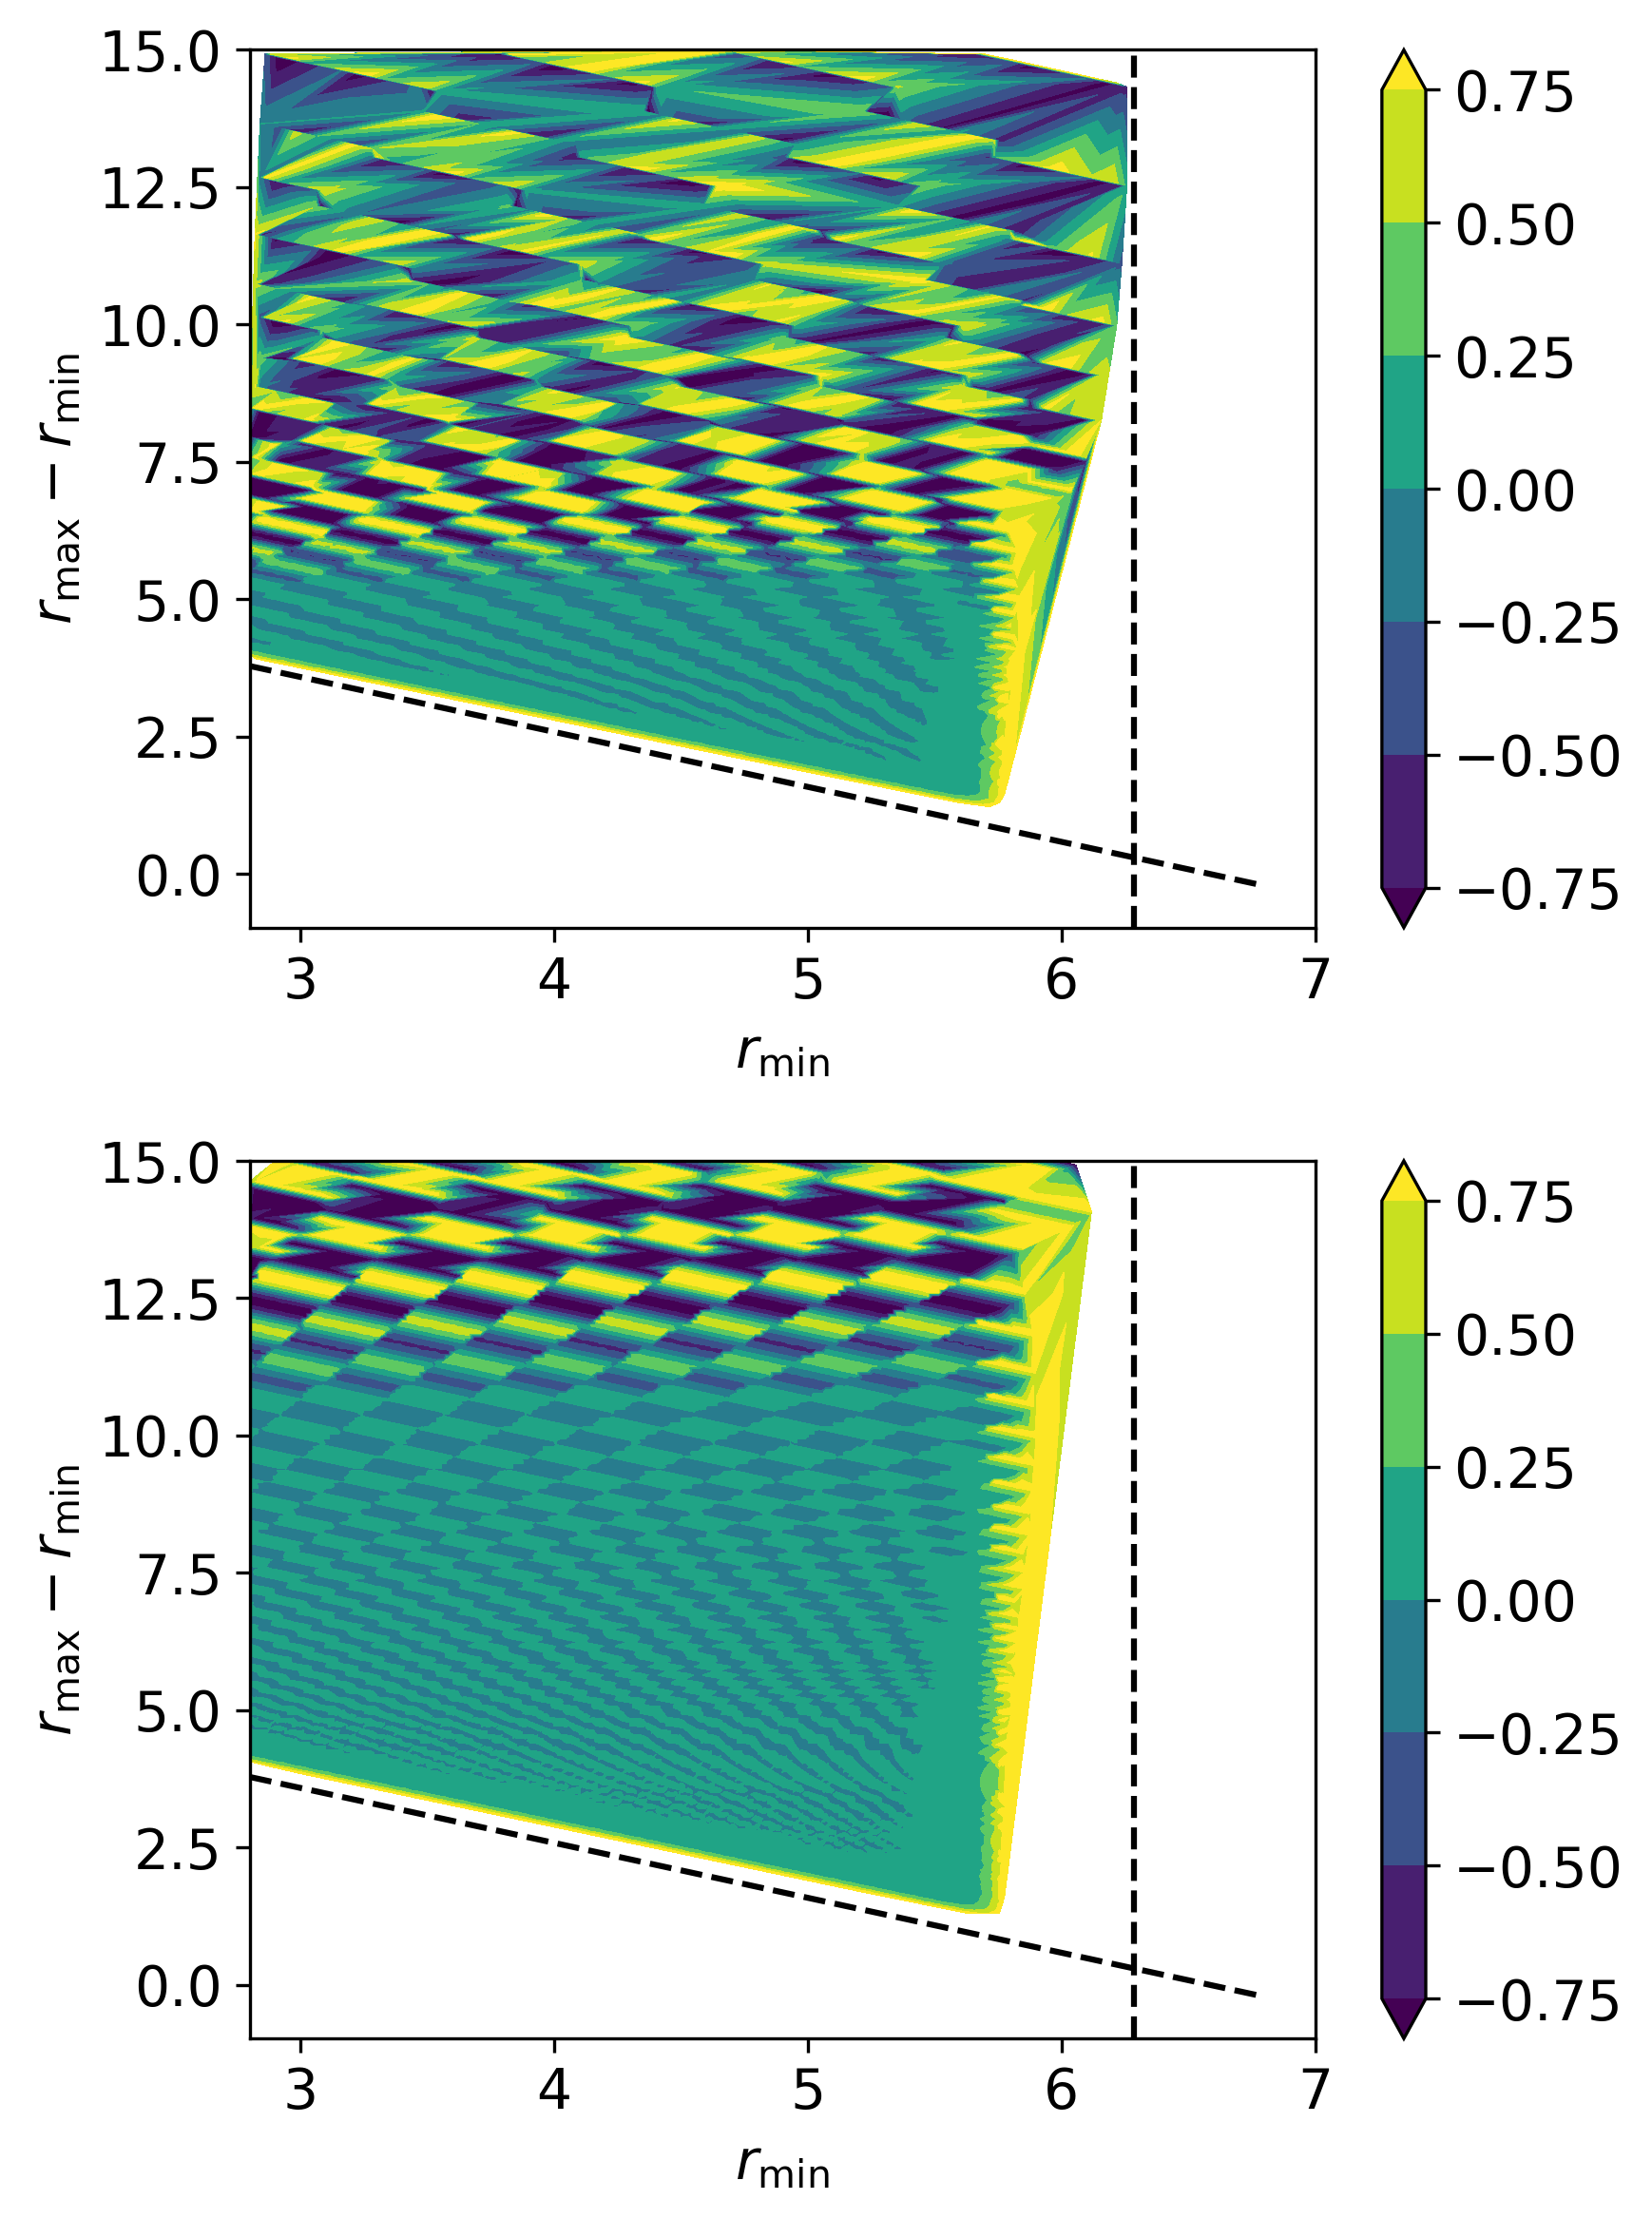

In [81]:
# ax.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# e_refs = [-15358.93684293, -9862.06667487, -7566.52568343, -6519.00988272, -5348.79450816, -3677.68306697, -548.68107280]
e_refs = [-548.68107280]
spins = [13]
# spins = [1, 3, 5, 7, 9, 11, 13]
error = 0.1

i = 0
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es_list_16[i]

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
            
# ax1.scatter(r_mins[es < e_refs[i] - error], drs[es < e_refs[i] - error], c='red', s=0.8)
# ax1.scatter(r_mins[es > e_refs[i] + error], drs[es > e_refs[i] + error], c='blue', s=0.8)
# ax1.scatter(r_mins[(es > e_refs[i] - error) & (es < e_refs[i] + error)], 
#             drs[(es > e_refs[i] - error) & (es < e_refs[i] + error)], c='green', s=0.8)
inds = np.abs(es - e_refs[i]) < 1
contour16 = ax1.tricontourf(r_mins[inds], drs[inds], es[inds] - e_refs[i], extend='both')
fig.colorbar(contour16)

# ax1.set_xlim(2.8, 6.5)
# ax1.set_ylim(0.1, 10)

ax1.set_xlabel('$r_{\\rm min}$')
ax1.set_ylabel('$r_{\\rm max} - r_{\\rm min}$')
print(np.min(es))

ax1.axvline(pot_mins[i], ls='--', c='black')
ax1.plot(np.arange(2.8, 7), pot_mins[i] - np.arange(2.5, 7), ls='dashed', c='black')

es = es_list_32[i]
ax2 = plt.subplot(212)
            
# ax2.scatter(r_mins[es < e_refs[i] - error], drs[es < e_refs[i] - error], c='red', s=0.8)
# ax2.scatter(r_mins[es > e_refs[i] + error], drs[es > e_refs[i] + error], c='blue', s=0.8)
# ax2.scatter(r_mins[(es > e_refs[i] - error) & (es < e_refs[i] + error)], 
#             drs[(es > e_refs[i] - error) & (es < e_refs[i] + error)], c='green', s=0.8)
inds = np.abs(es - e_refs[i]) < 1
contour32 = ax2.tricontourf(r_mins[inds], drs[inds], es[inds] - e_refs[i], extend='both')
fig.colorbar(contour32)

# ax2.set_xlim(2.8, 6.5)
# ax2.set_ylim(0.1, 10)

ax2.set_xlabel('$r_{\\rm min}$')
ax2.set_ylabel('$r_{\\rm max} - r_{\\rm min}$')
print(np.min(es))

ax2.axvline(pot_mins[i], ls='--', c='black')
ax2.plot(np.arange(2.8, 7), pot_mins[i] - np.arange(2.5, 7), ls='dashed', c='black')
plt.tight_layout()

13
-515.6856104704639
-509.6504846078234


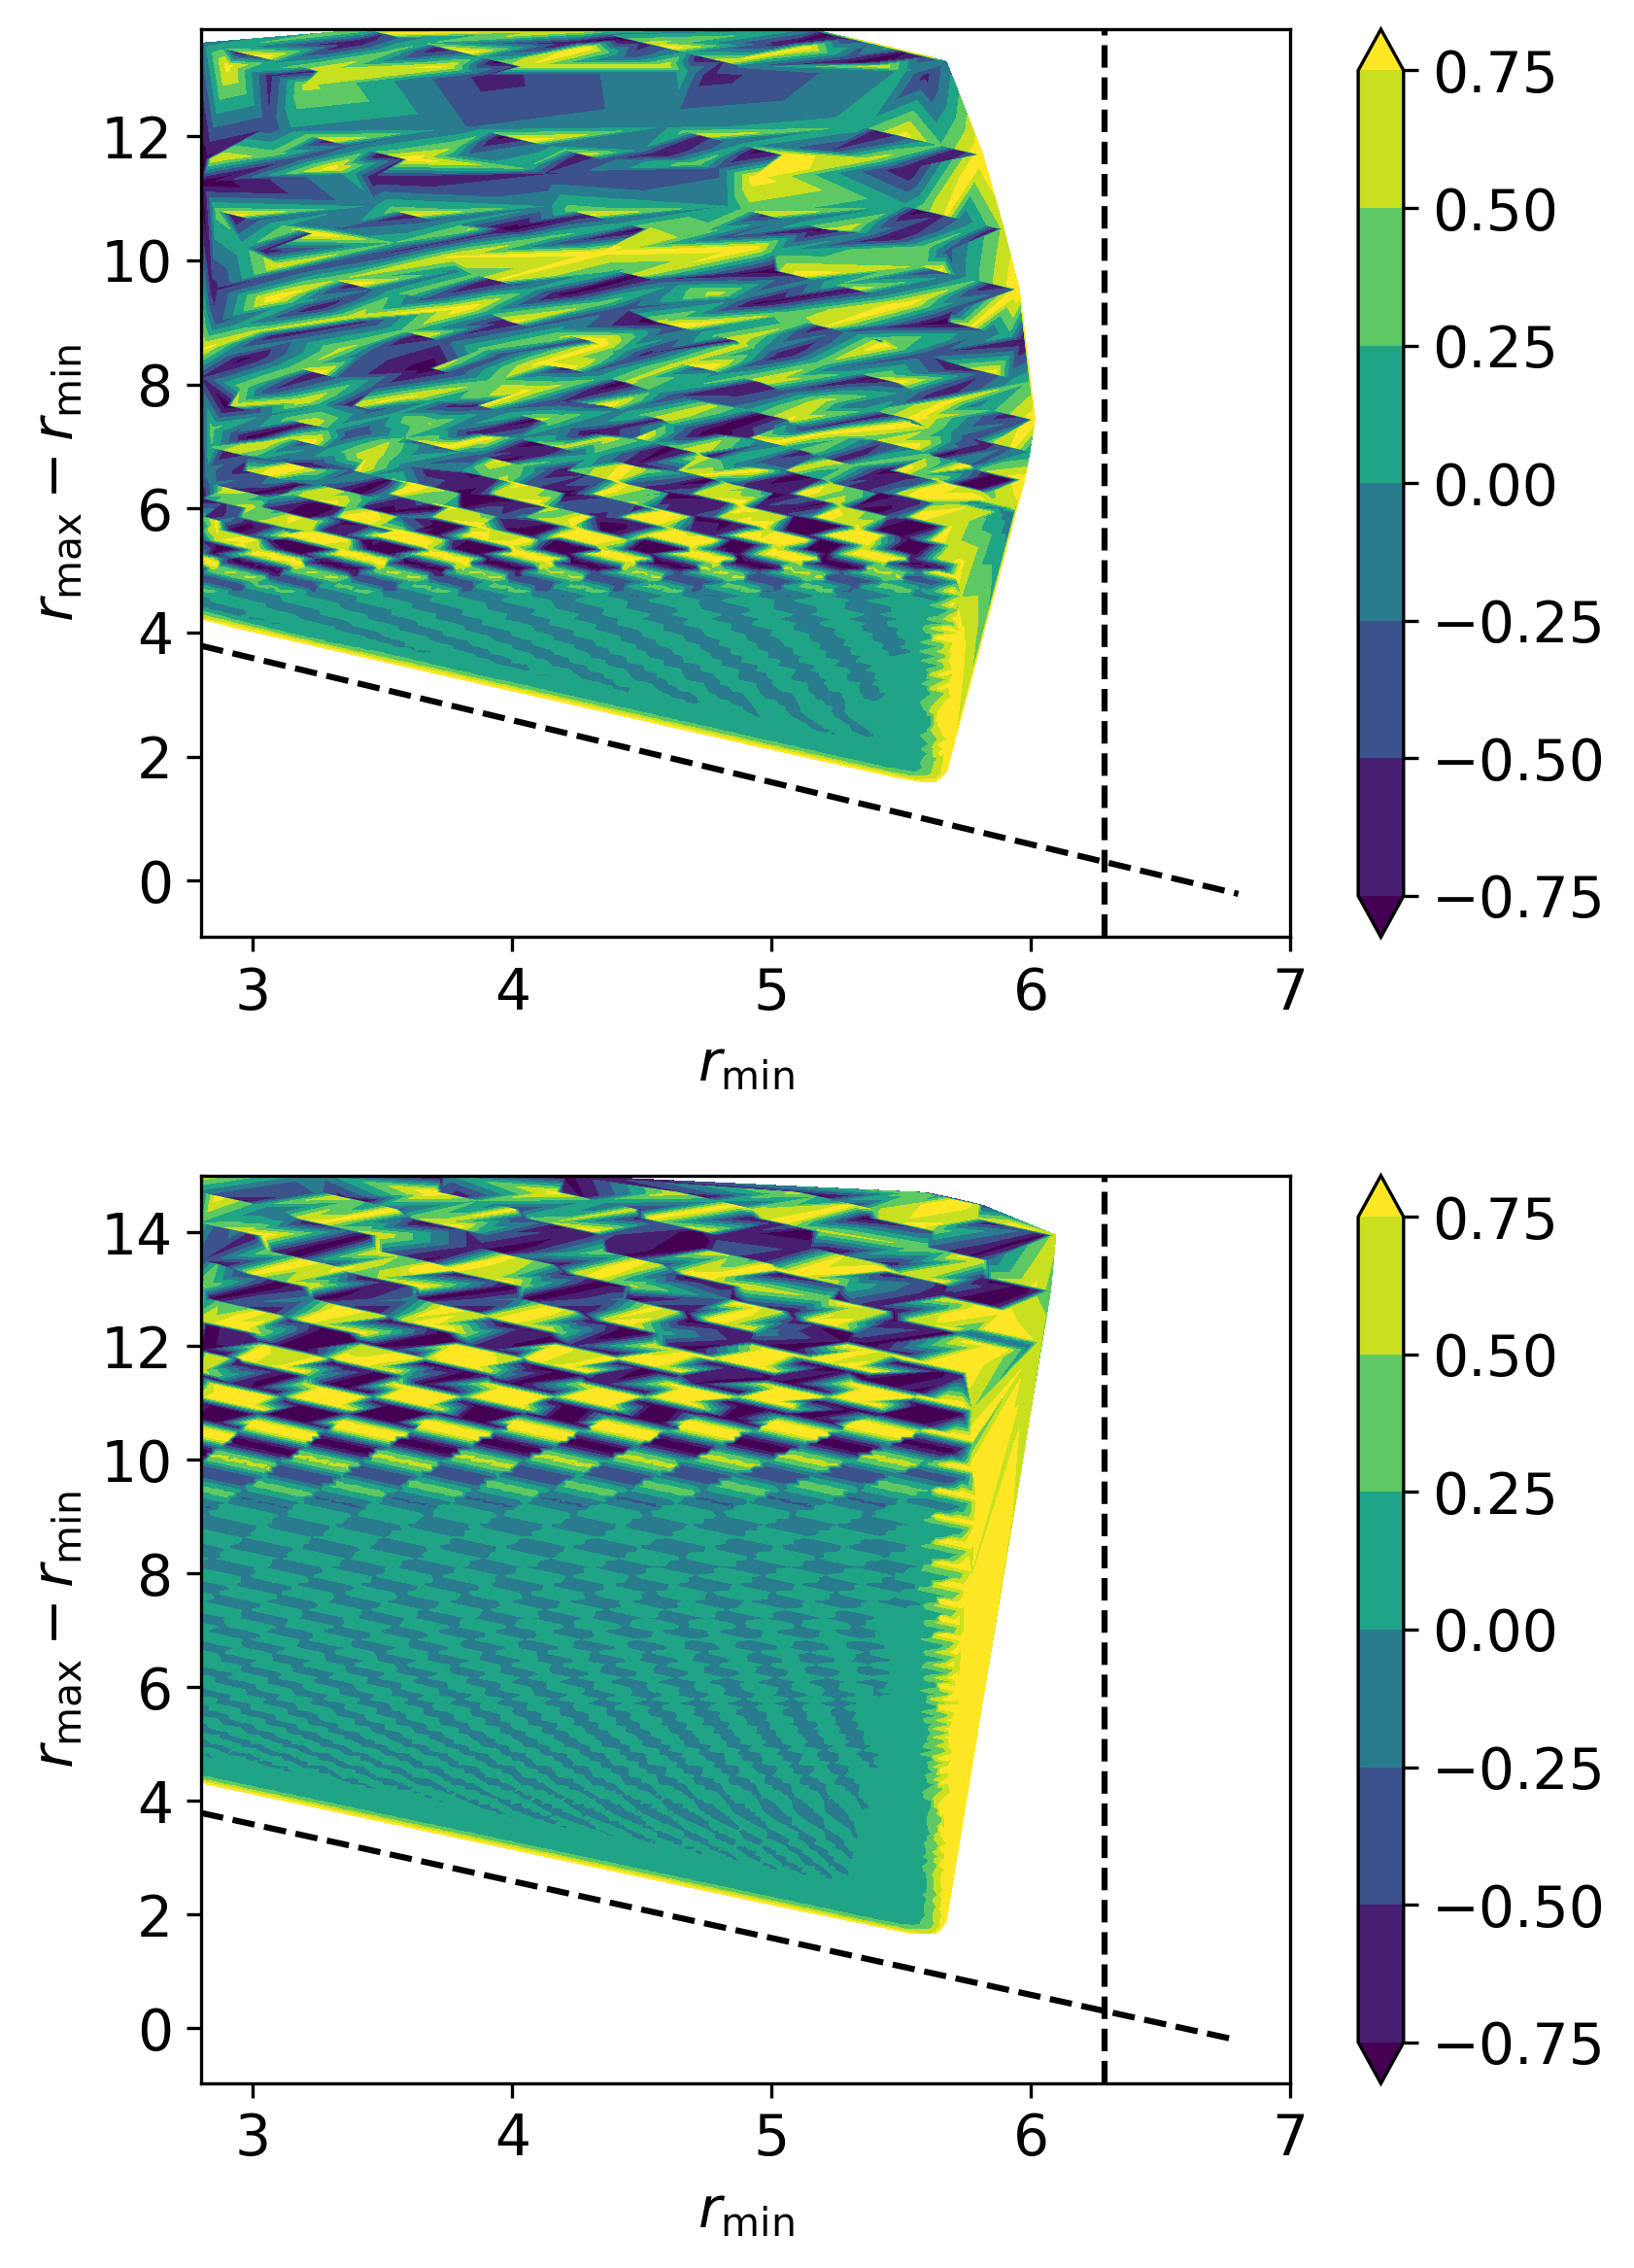

In [79]:
# ax.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# e2_refs = [-15358.93684293, -9862.06667487, -7566.52568343, -6519.00988272, -5348.79450816, -3677.68306697, -548.68107280]
e_refs = [-548.68107280]
e2_refs = [-497.15859133]
spins = [13]
# spins = [1, 3, 5, 7, 9, 11, 13]
error = 0.1

i = 0
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es2_list_16[i]

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
            
# ax1.scatter(r_mins[es < e2_refs[i] - error], drs[es < e2_refs[i] - error], c='red', s=0.8)
# ax1.scatter(r_mins[es > e2_refs[i] + error], drs[es > e2_refs[i] + error], c='blue', s=0.8)
# ax1.scatter(r_mins[(es > e2_refs[i] - error) & (es < e2_refs[i] + error)], 
#             drs[(es > e2_refs[i] - error) & (es < e2_refs[i] + error)], c='green', s=0.8)
inds = np.abs(es - e2_refs[i]) < 1
contour16 = ax1.tricontourf(r_mins[inds], drs[inds], es[inds] - e2_refs[i], extend='both')
fig.colorbar(contour16)

# ax1.set_xlim(2.8, 6.5)
# ax1.set_ylim(0.1, 10)

ax1.set_xlabel('$r_{\\rm min}$')
ax1.set_ylabel('$r_{\\rm max} - r_{\\rm min}$')
print(np.min(es))

ax1.axvline(pot_mins[i], ls='--', c='black')
ax1.plot(np.arange(2.8, 7), pot_mins[i] - np.arange(2.5, 7), ls='dashed', c='black')

es = es2_list_32[i]
ax2 = plt.subplot(212)
            
# ax2.scatter(r_mins[es < e2_refs[i] - error], drs[es < e2_refs[i] - error], c='red', s=0.8)
# ax2.scatter(r_mins[es > e2_refs[i] + error], drs[es > e2_refs[i] + error], c='blue', s=0.8)
# ax2.scatter(r_mins[(es > e2_refs[i] - error) & (es < e2_refs[i] + error)], 
#             drs[(es > e2_refs[i] - error) & (es < e2_refs[i] + error)], c='green', s=0.8)
inds = np.abs(es - e2_refs[i]) < 1
contour32 = ax2.tricontourf(r_mins[inds], drs[inds], es[inds] - e2_refs[i], extend='both')
fig.colorbar(contour32)

# ax2.set_xlim(2.8, 6.5)
# ax2.set_ylim(0.1, 10)

ax2.set_xlabel('$r_{\\rm min}$')
ax2.set_ylabel('$r_{\\rm max} - r_{\\rm min}$')
print(np.min(es))

ax2.axvline(pot_mins[i], ls='--', c='black')
ax2.plot(np.arange(2.8, 7), pot_mins[i] - np.arange(2.5, 7), ls='dashed', c='black')
plt.tight_layout()

13
-566.7388086463559
-552.2589912721023


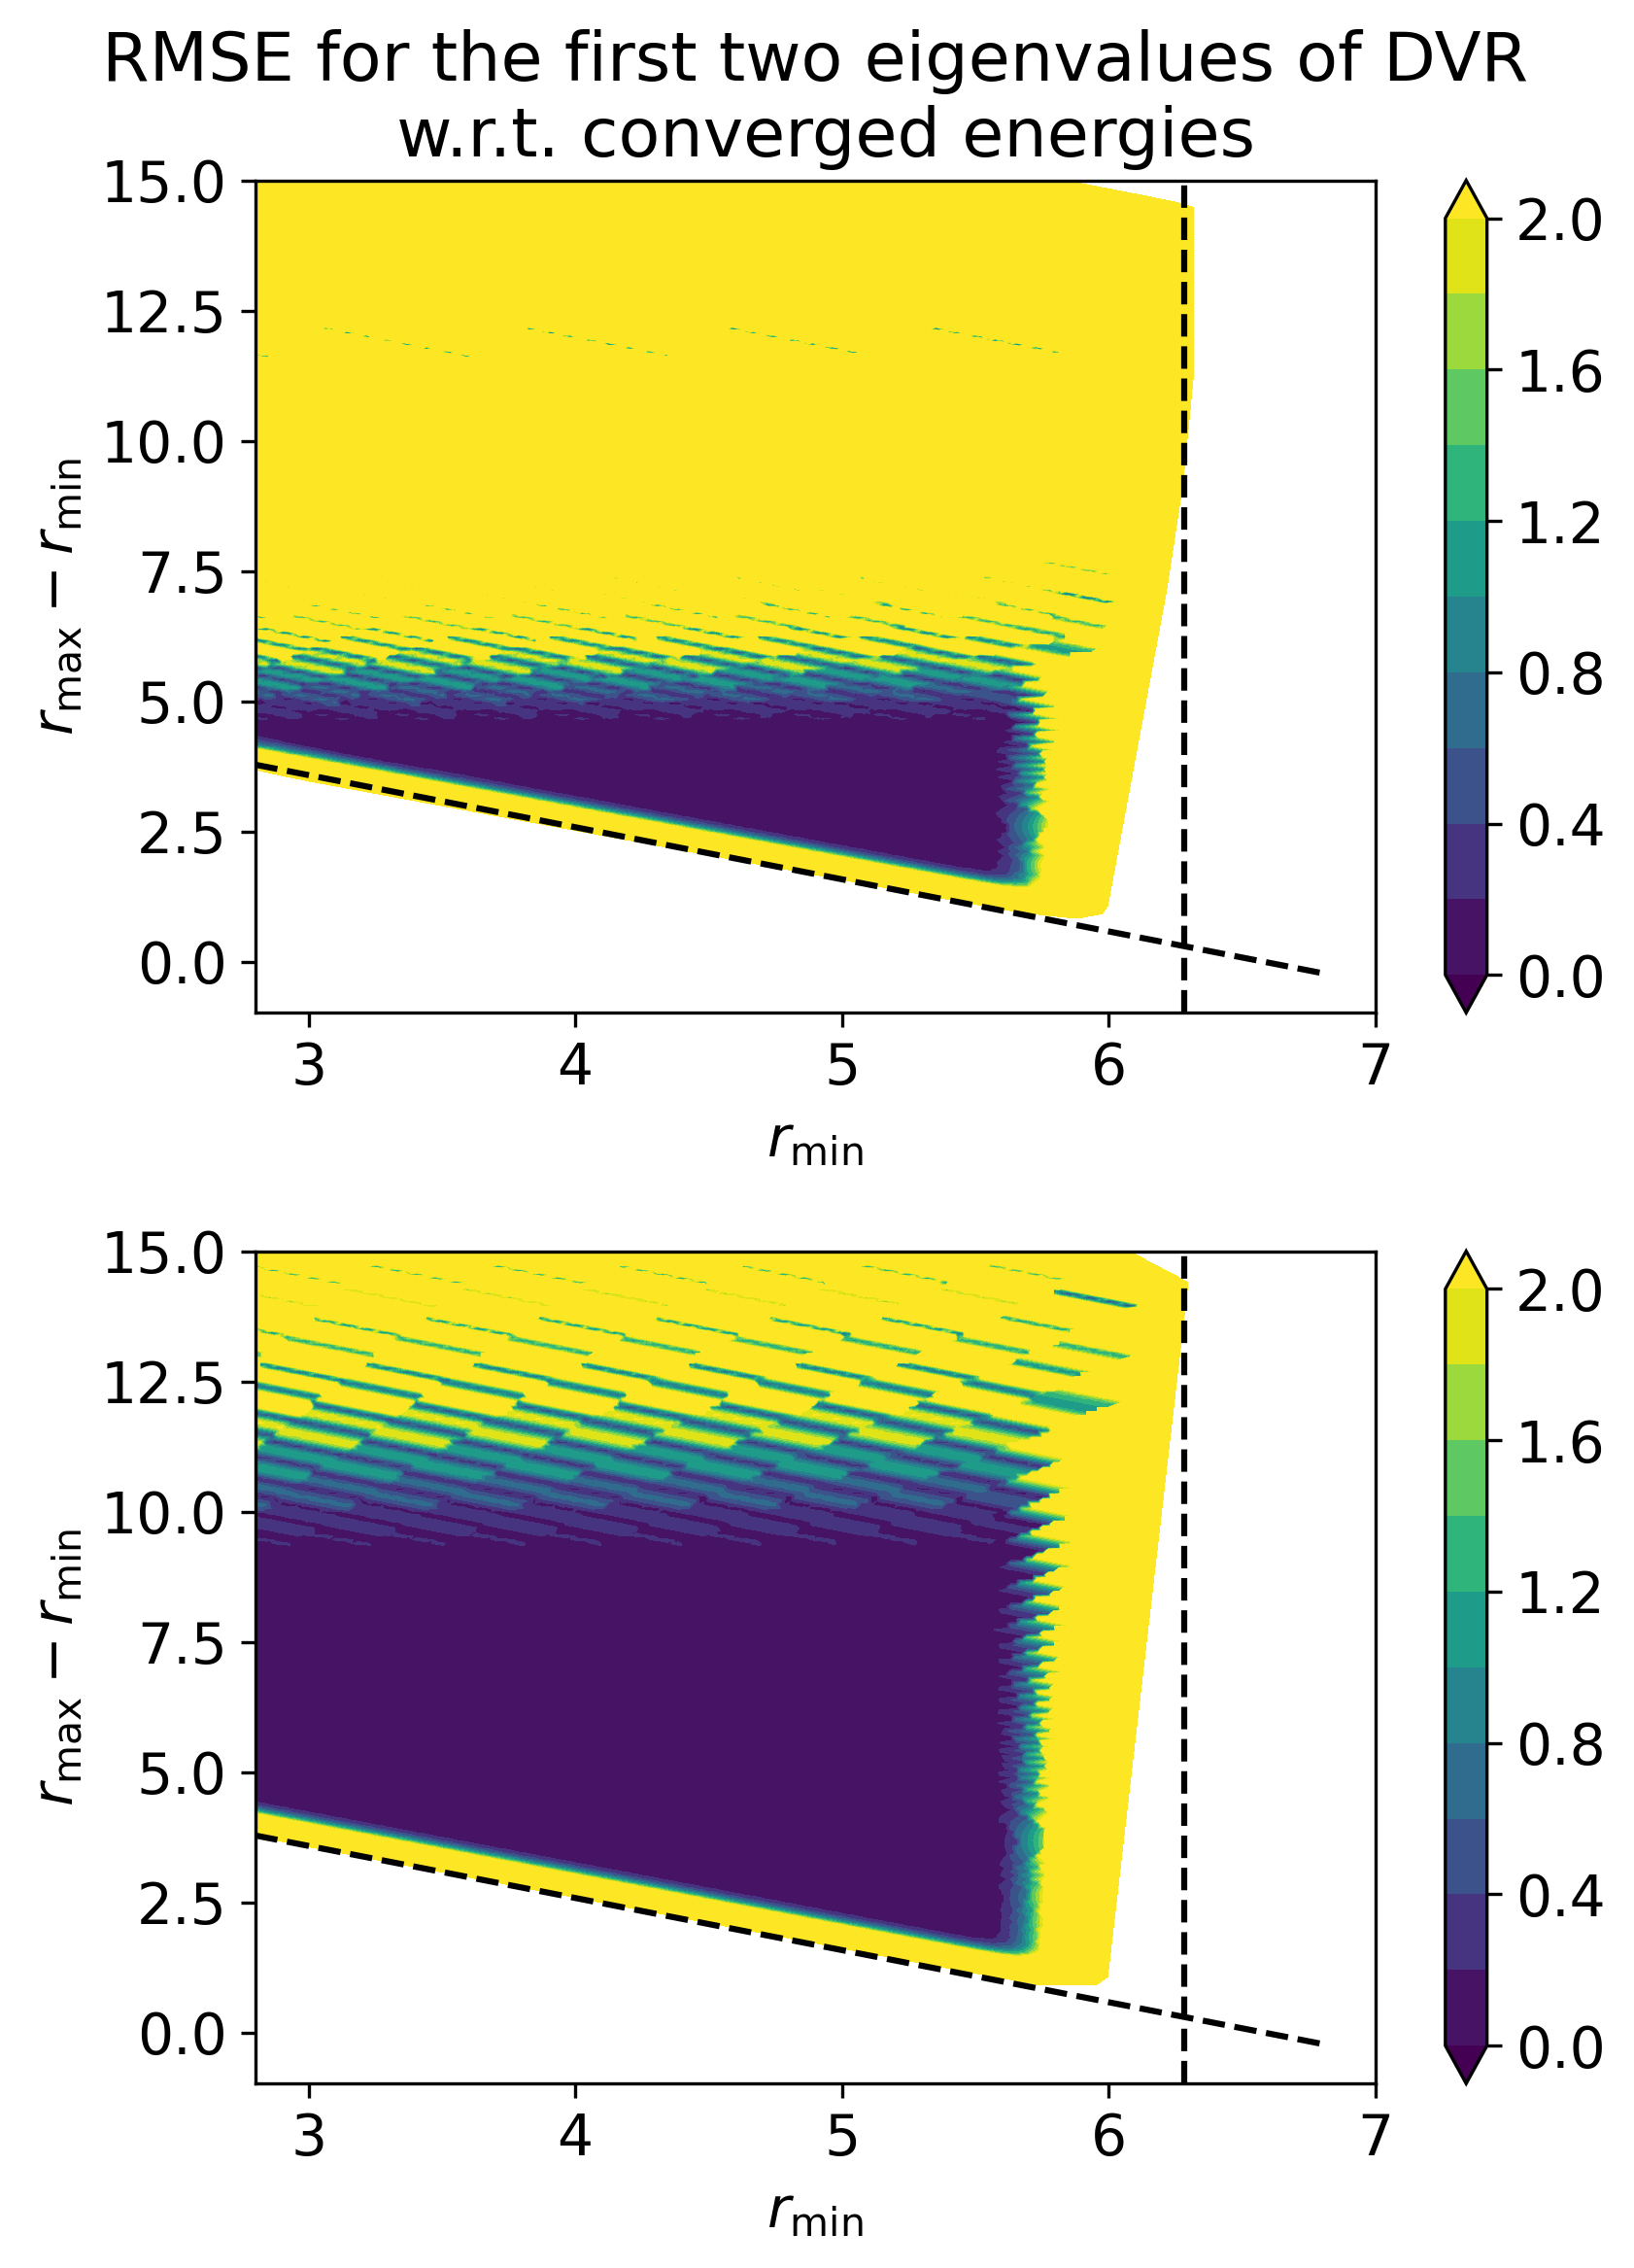

In [101]:
# ax.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# e2_refs = [-15358.93684293, -9862.06667487, -7566.52568343, -6519.00988272, -5348.79450816, -3677.68306697, -548.68107280]
e_refs = [-548.68107280]
e2_refs = [-497.15859133]
spins = [13]
# spins = [1, 3, 5, 7, 9, 11, 13]
error = 0.1

i = 0
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es_list_16[i]
es2 = es2_list_16[i]

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
            
# ax1.scatter(r_mins[es < e2_refs[i] - error], drs[es < e2_refs[i] - error], c='red', s=0.8)
# ax1.scatter(r_mins[es > e2_refs[i] + error], drs[es > e2_refs[i] + error], c='blue', s=0.8)
# ax1.scatter(r_mins[(es > e2_refs[i] - error) & (es < e2_refs[i] + error)], 
#             drs[(es > e2_refs[i] - error) & (es < e2_refs[i] + error)], c='green', s=0.8)
inds = np.abs(es - e_refs[i]) < 10
contour16 = ax1.tricontourf(r_mins[inds], drs[inds], np.sqrt(0.5 * (np.square(es[inds] - e_refs[i]) + np.square(es2[inds] - e2_refs[i]))), 
                            extend='both', levels=np.linspace(0, 2, 11))
fig.colorbar(contour16)

# ax1.set_xlim(2.8, 6.5)
# ax1.set_ylim(0.1, 10)

ax1.set_xlabel('$r_{\\rm min}$')
ax1.set_ylabel('$r_{\\rm max} - r_{\\rm min}$')
print(np.min(es))

ax1.axvline(pot_mins[i], ls='--', c='black')
ax1.plot(np.arange(2.8, 7), pot_mins[i] - np.arange(2.5, 7), ls='dashed', c='black')

es = es_list_32[i]
es2 = es2_list_32[i]
ax2 = plt.subplot(212)
            
# ax2.scatter(r_mins[es < e2_refs[i] - error], drs[es < e2_refs[i] - error], c='red', s=0.8)
# ax2.scatter(r_mins[es > e2_refs[i] + error], drs[es > e2_refs[i] + error], c='blue', s=0.8)
# ax2.scatter(r_mins[(es > e2_refs[i] - error) & (es < e2_refs[i] + error)], 
#             drs[(es > e2_refs[i] - error) & (es < e2_refs[i] + error)], c='green', s=0.8)
inds = np.abs(es - e_refs[i]) < 10
contour32 = ax2.tricontourf(r_mins[inds], drs[inds], np.sqrt(0.5 * (np.square(es[inds] - e_refs[i]) + np.square(es2[inds] - e2_refs[i]))), 
                            extend='both', levels=np.linspace(0, 2, 11))
fig.colorbar(contour32)

# ax2.set_xlim(2.8, 6.5)
# ax2.set_ylim(0.1, 10)

ax2.set_xlabel('$r_{\\rm min}$')
ax2.set_ylabel('$r_{\\rm max} - r_{\\rm min}$')
print(np.min(es))

ax2.axvline(pot_mins[i], ls='--', c='black')
ax2.plot(np.arange(2.8, 7), pot_mins[i] - np.arange(2.5, 7), ls='dashed', c='black')
ax1.set_title('RMSE for the first two eigenvalues of DVR\n w.r.t. converged energies')
plt.tight_layout()

In [35]:
spin = 13
n = 16
# print(params)
r_min = r_mins[np.argmin(es_16)]
r_max = r_min + drs[np.argmin(es_16)]
dvr_options = {
    'type': '1d',
    'box_lims': (r_min, r_max),
    'dx': (r_max - r_min) / n,
    'count': n
}

pot, lims = get_pot_cr2(spin)
print(lims)
dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')
r_dvr = dvr_vqe.get_DVR_Rtheta(dvr_options)
print(r_dvr)

(2.8, 40.0)
[ 3.59365247  4.49206559  5.39047871  6.28889183  7.18730495  8.08571806
  8.98413118  9.8825443  10.78095742 11.67937054 12.57778366 13.47619677
 14.37460989 15.27302301 16.17143613 17.06984925]


In [38]:
np.min(pot(r_new)) * hartree

-575.830258035607

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(-800.0, 2000.0)

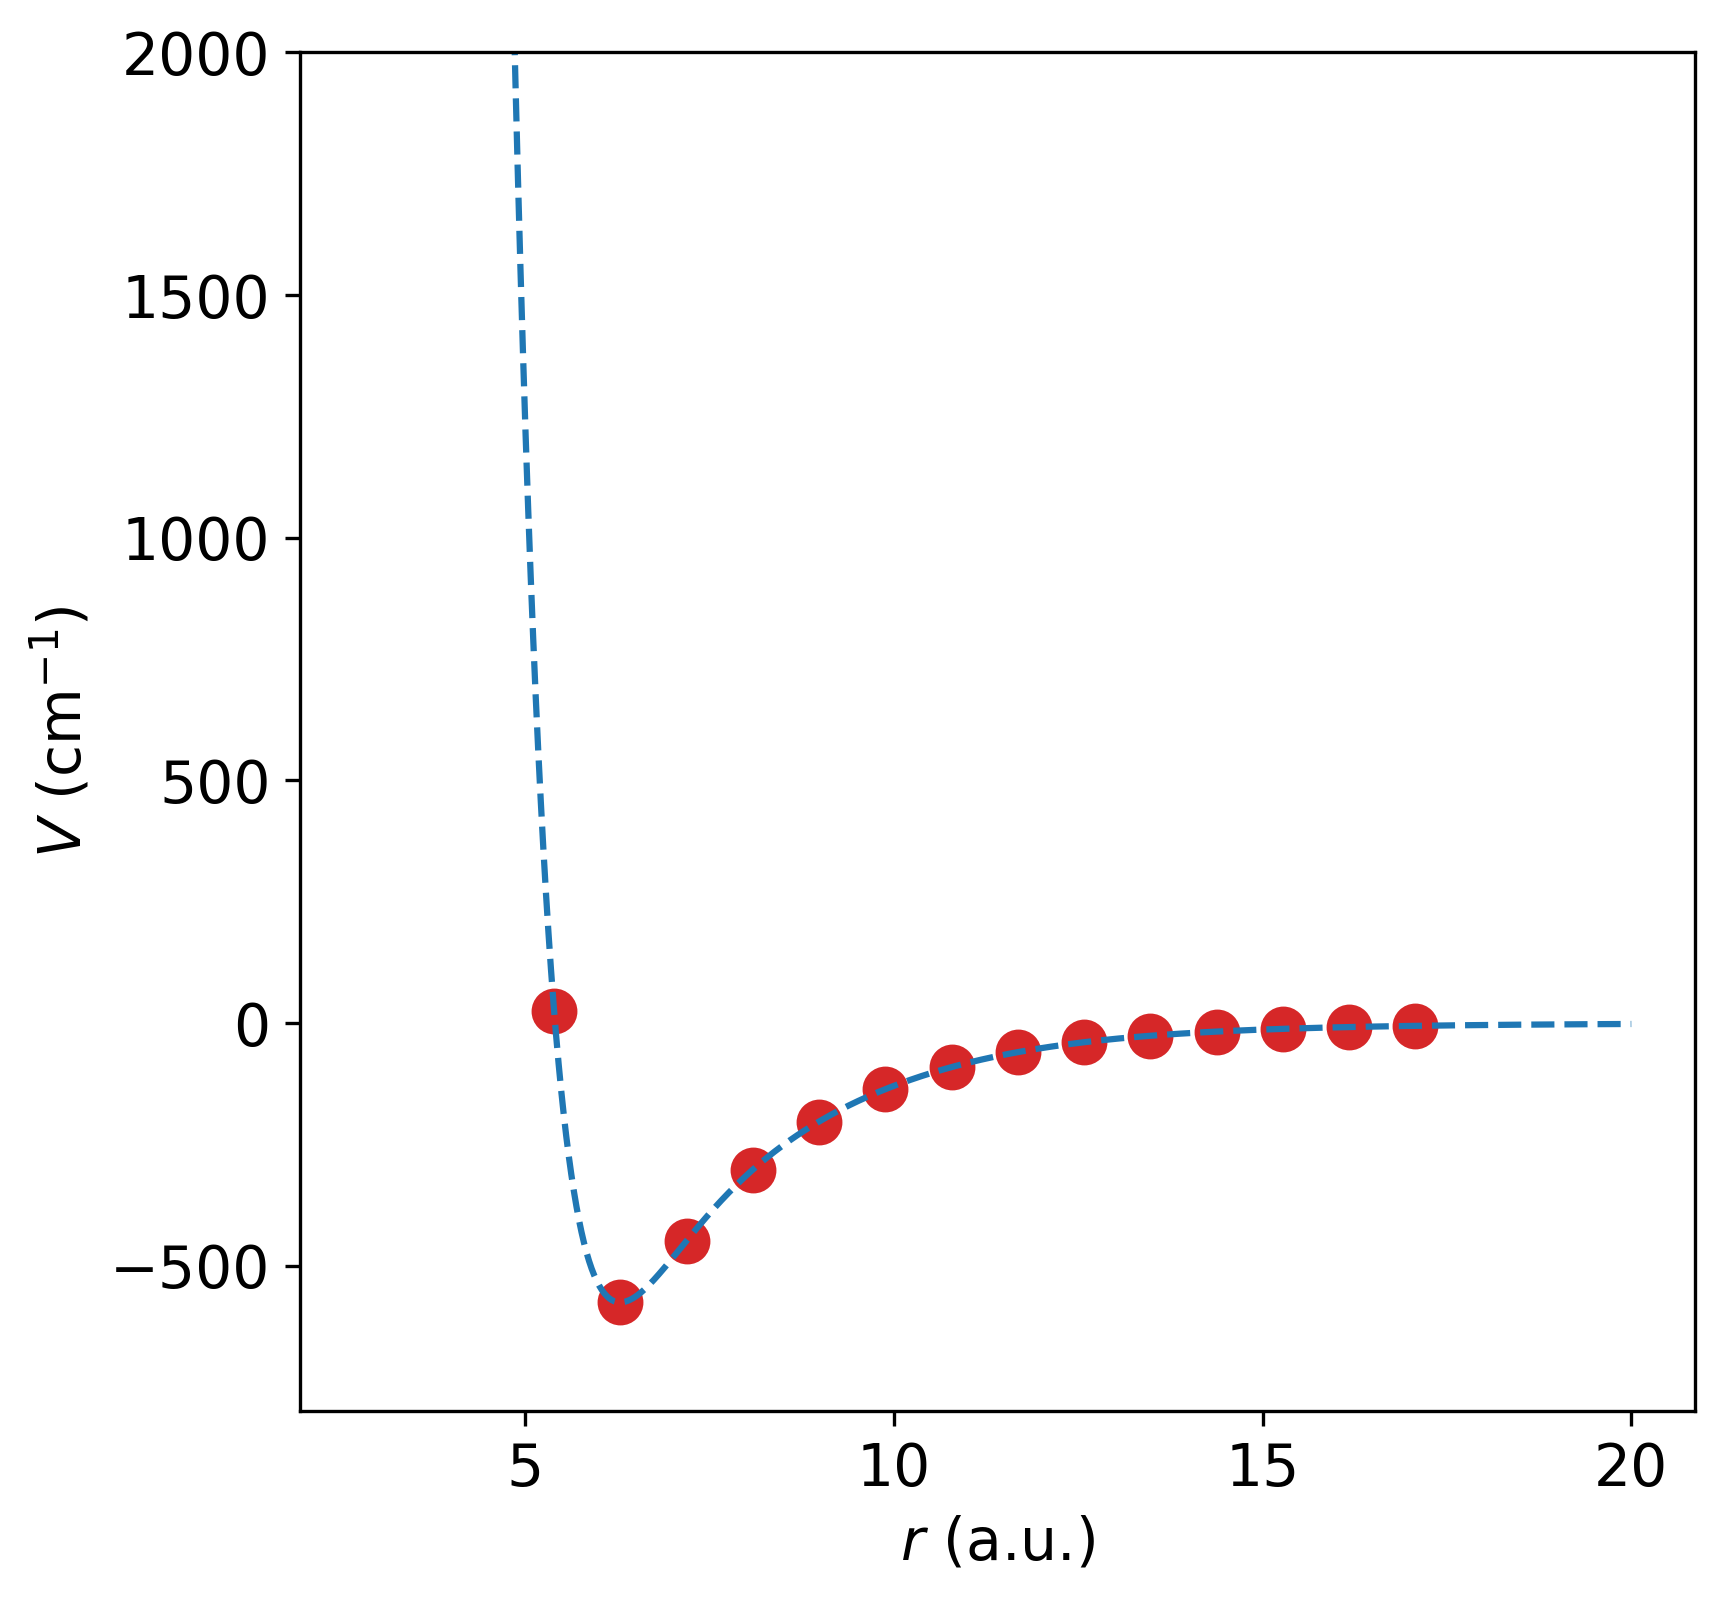

In [36]:
r_new = np.linspace(lims[0], 20, 1000)
cmap = plt.get_cmap('tab10')
plt.plot(r_new, pot(r_new) * hartree, '--', c=cmap(0))
# plt.scatter(r_box1, v1 * hartree, marker='o', s=100, c=cmap(1))
plt.scatter(r_dvr, pot(r_dvr) * hartree, marker='o', s=100, c=cmap(3))
plt.xlabel('$r$ (a.u.)')
plt.ylabel('$V$ (cm$^{-1}$)')
plt.ylim(-800, 2000)
#-540.2707144837274882 0.001 5-8
#-548.6810730737634003

In [51]:
from matplotlib.patches import Polygon
# ax.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# e_refs = [-15358.93684293, -9862.06667487, -7566.52568343, -6519.00988272, -5348.79450816, -3677.68306697, -548.68107280]
e_refs = [-548.68107280]
spins = [13]
# spins = [1, 3, 5, 7, 9, 11, 13]
error = 0.1

i = 0
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es_list[i]

ax = plt.subplot()
# ax.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# ax.colorbar()
# ax.scatter(r_mins[es < e_refs[i] - error], r_maxs[es < e_refs[i] - error], c='red', s=1)
# ax.scatter(r_mins[es > e_refs[i] + error], r_maxs[es > e_refs[i] + error], c='blue', s=1)
# ax.scatter(r_mins[(es > e_refs[i] - error) & (es < e_refs[i] + error)], 
#             r_maxs[(es > e_refs[i] - error) & (es < e_refs[i] + error)], c='green', s=1)
            
# ax.scatter(r_mins[es < e_refs[i] - error], drs[es < e_refs[i] - error], c='red', s=0.8)
# ax.scatter(r_mins[es > e_refs[i] + error], drs[es > e_refs[i] + error], c='blue', s=0.8)
# ax.scatter(r_mins[(es > e_refs[i] - error) & (es < e_refs[i] + error)], 
#             drs[(es > e_refs[i] - error) & (es < e_refs[i] + error)], c='green', s=0.8)


# ax.scatter(2.8, 4)
# # ax.yscale('log')
# ax.xlim(2.5, 8)
# ax.ylim(2.5, 8)

# ax.yscale('log')
ax.set_xlim(2.8, 6.5)
ax.set_ylim(0.1, 10)

ax.set_xlabel('$r_{\\rm min}$')
ax.set_ylabel('$r_{\\rm max} - r_{\\rm min}$')
print(np.min(es))

ax.axvline(pot_mins[i], ls='--', c='black')
ax.plot(np.arange(2.8, 8), pot_mins[i] - np.arange(2.5, 8), ls='dashed', c='black')
# ax.axhline(4.8, c='black')

x1 = (2.8, 2.8)
x2 = (5.65, 5.75)
y1 = (4.1, 1.4)
y2 = (4.8, 4.8)
pad = [0, 0.2, 0, 0]
good_points = RoundedPolygon([[x1[0], y1[0]], [x2[0], y1[1]], [x2[1], y2[1]], [x1[1], y2[0]]], fill=True, pad=pad, 
                            lw=0, alpha=0.5, facecolor='green')
ax.add_patch(good_points, )

x1 = (2.8, 2.8)
x2 = (5.75, 6.25)
y1 = (4.8, 4.8)
y2 = (10, 10)
pad = [0, 0, 0, 0]
bad_points = RoundedPolygon([[x1[0], y1[0]], [x2[0], y1[1]], [x2[1], y2[1]], [x1[1], y2[0]]], fill=True, pad=pad, 
                            lw=0, alpha=0.5, facecolor='red')
ax.add_patch(bad_points, )
# ax.fill_between(x, y1, y2, alpha=0.6, capstyle='round')

# x = np.arange(2.8, 5.8, 0.1)
# y1 = x * (-0.94) + 6.7
# y2 = 4.8
# plt.fill_between(x, y1, y2, alpha=0.6)
# r_new = np.linspace(lims[0], lims[0] + 5, 200)
# ax.plot(r_new, pot(r_new) * hartree, '--')
# ax.ylim(-1000, 5000)
# ax.show()

# r_new = np.linspace(lims[0] + 1, lims[0] + 20, 200)
# ax.plot(pot(r_new) * hartree, r_new, '--')
# ax.xlim(5000, -1000)
# ax.show()
ax.scatter(5.2, 3.8, marker='x', c='black')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# ax.spines.left.set_visible(False)
# ax.spines.bottom.set_visible(False)

13


NameError: name 'es_list' is not defined

[-548.6810728]
-566.7388086463559
3.342713567839196
13.72713567839196


In [118]:
r_mins_list = []
drs_list = []
es_list = []
# es2_list_16 = []

for spin in [13]:
    mol_params = cr2_params
    mol_params['name'] = f'cr2_{spin}'
    print(mol_params['name'])

    pot, lims = get_pot_cr2(spin)
    # pot2 = pot
    # pot2 = lambda x: pot(x) + 2.623407937141139e-3
    print(lims)

    dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')
    # dvr_vqe2 = DVR_VQE(mol_params, pot2, log_dir=scratch_dir + 'test/')
    # bounds = [(lims[0], lims[0] + 5)]

    fun100 = lambda p: get_energies(p, dvr_vqe, 100)[0]
    # fun162 = lambda p: get_gs_energy(p, dvr_vqe2, bounds, 16)

    r_mins = np.linspace(lims[0], lims[0] + 5, 100)
    drs = np.linspace(0.1, 8, 100)
    r_mins, drs = np.meshgrid(r_mins, drs)
    r_mins = r_mins.flatten()
    drs = drs.flatten()

    es = np.array([fun100((r_mins[i], r_mins[i] + drs[i])) for i in range(len(r_mins))])
    # es2 = np.array([fun162((r_mins[i], dxs[i])) for i in range(len(r_mins))])

    r_mins_list.append(r_mins)
    drs_list.append(drs)
    es_list.append(es)

cr2_13
(2.8, 40.0)


13
-548.6812343337228
[False False False ... False False False]
-548.6812343337228


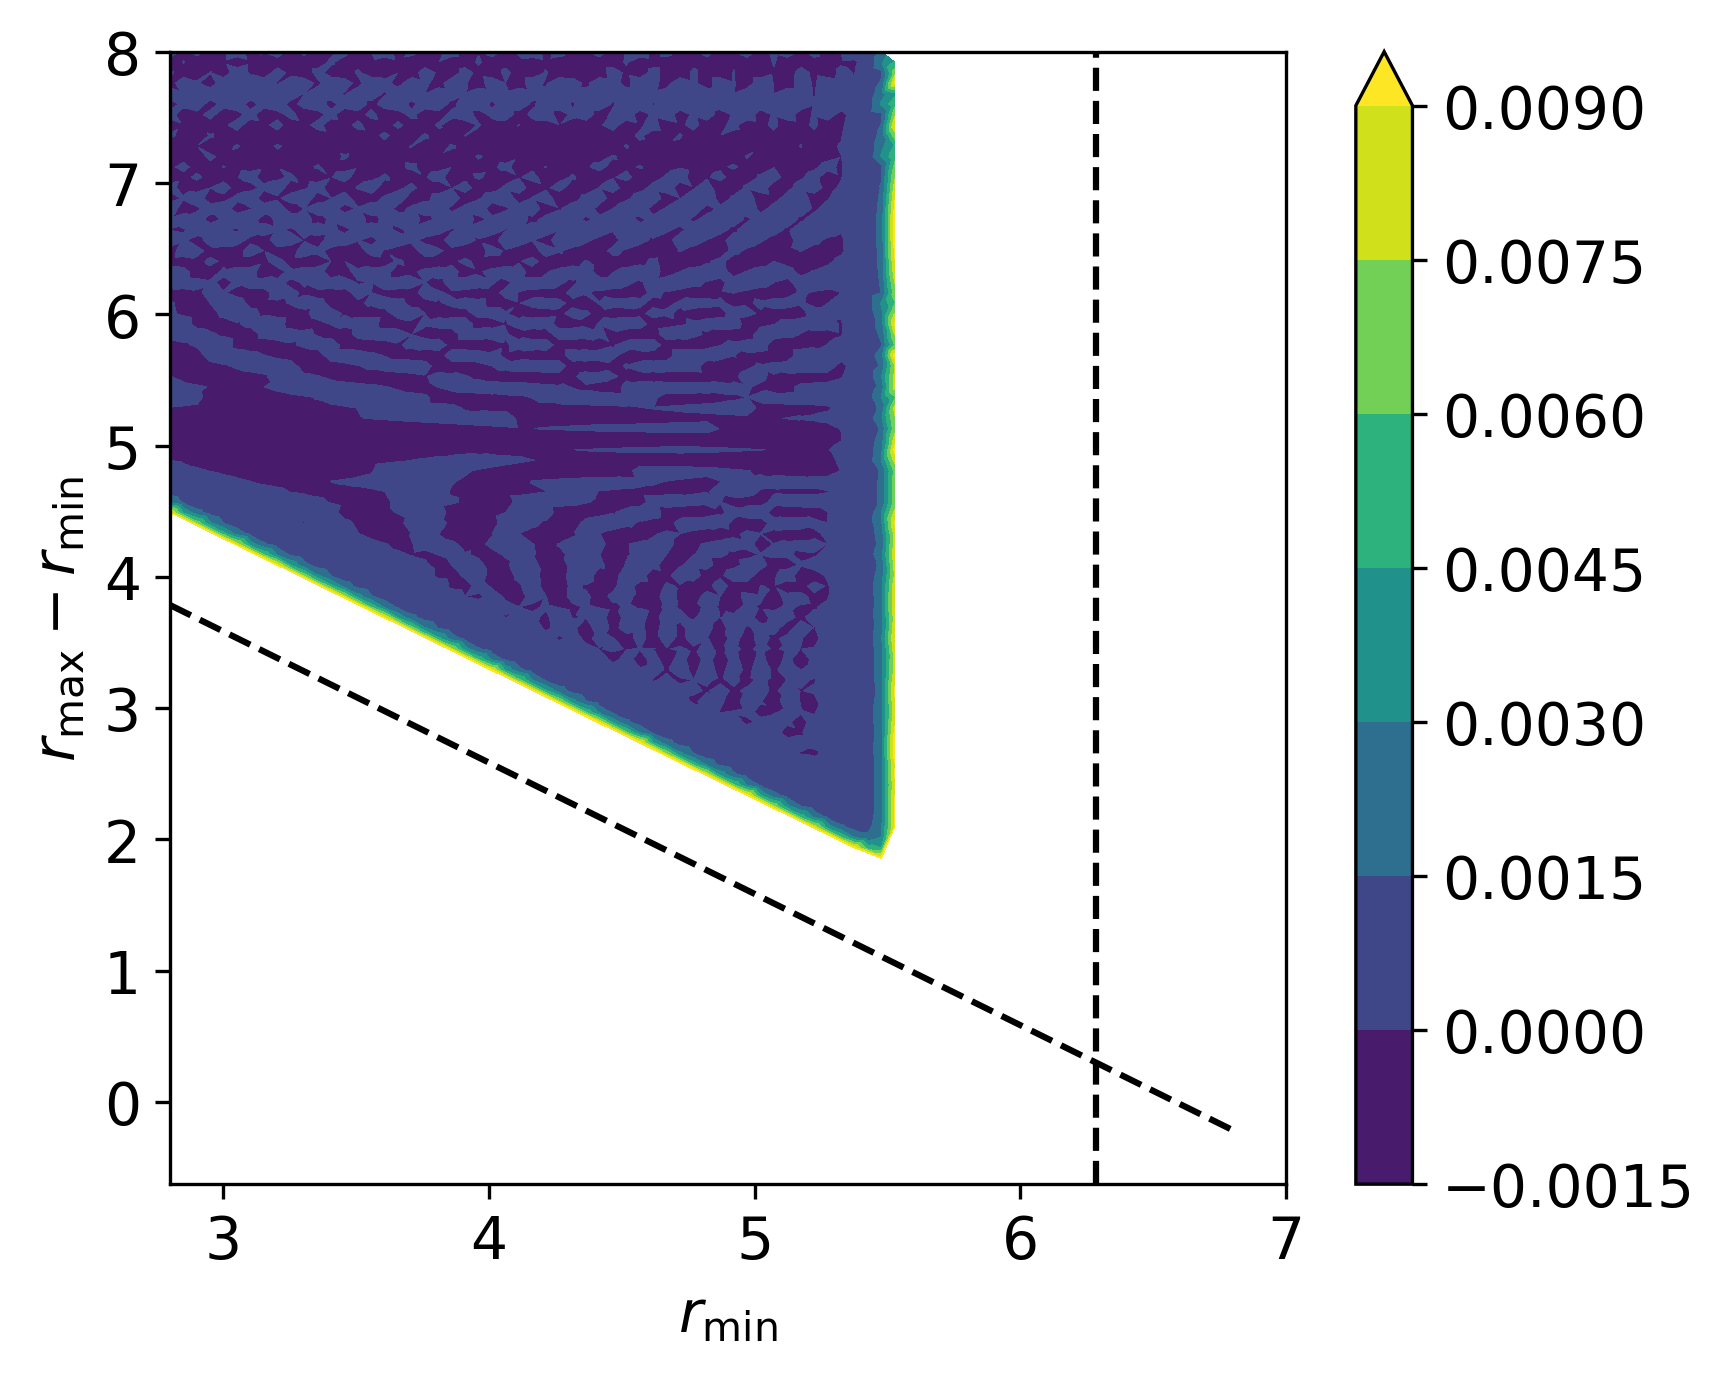

In [134]:
# ax.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# e2_refs = [-15358.93684293, -9862.06667487, -7566.52568343, -6519.00988272, -5348.79450816, -3677.68306697, -548.68107280]
e_refs = [-548.68107280]
spins = [13]
# spins = [1, 3, 5, 7, 9, 11, 13]
error = 0.1

i = 0
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es_list[i]
print(np.min(es))

fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(111)
            
# ax1.scatter(r_mins[es < e2_refs[i] - error], drs[es < e2_refs[i] - error], c='red', s=0.8)
# ax1.scatter(r_mins[es > e2_refs[i] + error], drs[es > e2_refs[i] + error], c='blue', s=0.8)
# ax1.scatter(r_mins[(es > e2_refs[i] - error) & (es < e2_refs[i] + error)], 
#             drs[(es > e2_refs[i] - error) & (es < e2_refs[i] + error)], c='green', s=0.8)
inds = np.abs(es - e_refs[i]) < 0.01
print(inds)
contour = ax1.tricontourf(r_mins[inds], drs[inds], es[inds] - e_refs[i], extend='max')
fig.colorbar(contour)

# ax1.set_xlim(2.8, 6.5)
# ax1.set_ylim(0.1, 10)

ax1.set_xlabel('$r_{\\rm min}$')
ax1.set_ylabel('$r_{\\rm max} - r_{\\rm min}$')
print(np.min(es))

ax1.axvline(pot_mins[i], ls='--', c='black')
ax1.plot(np.arange(2.8, 7), pot_mins[i] - np.arange(2.5, 7), ls='dashed', c='black')

# plt.tight_layout()

3
-10005.011058700826


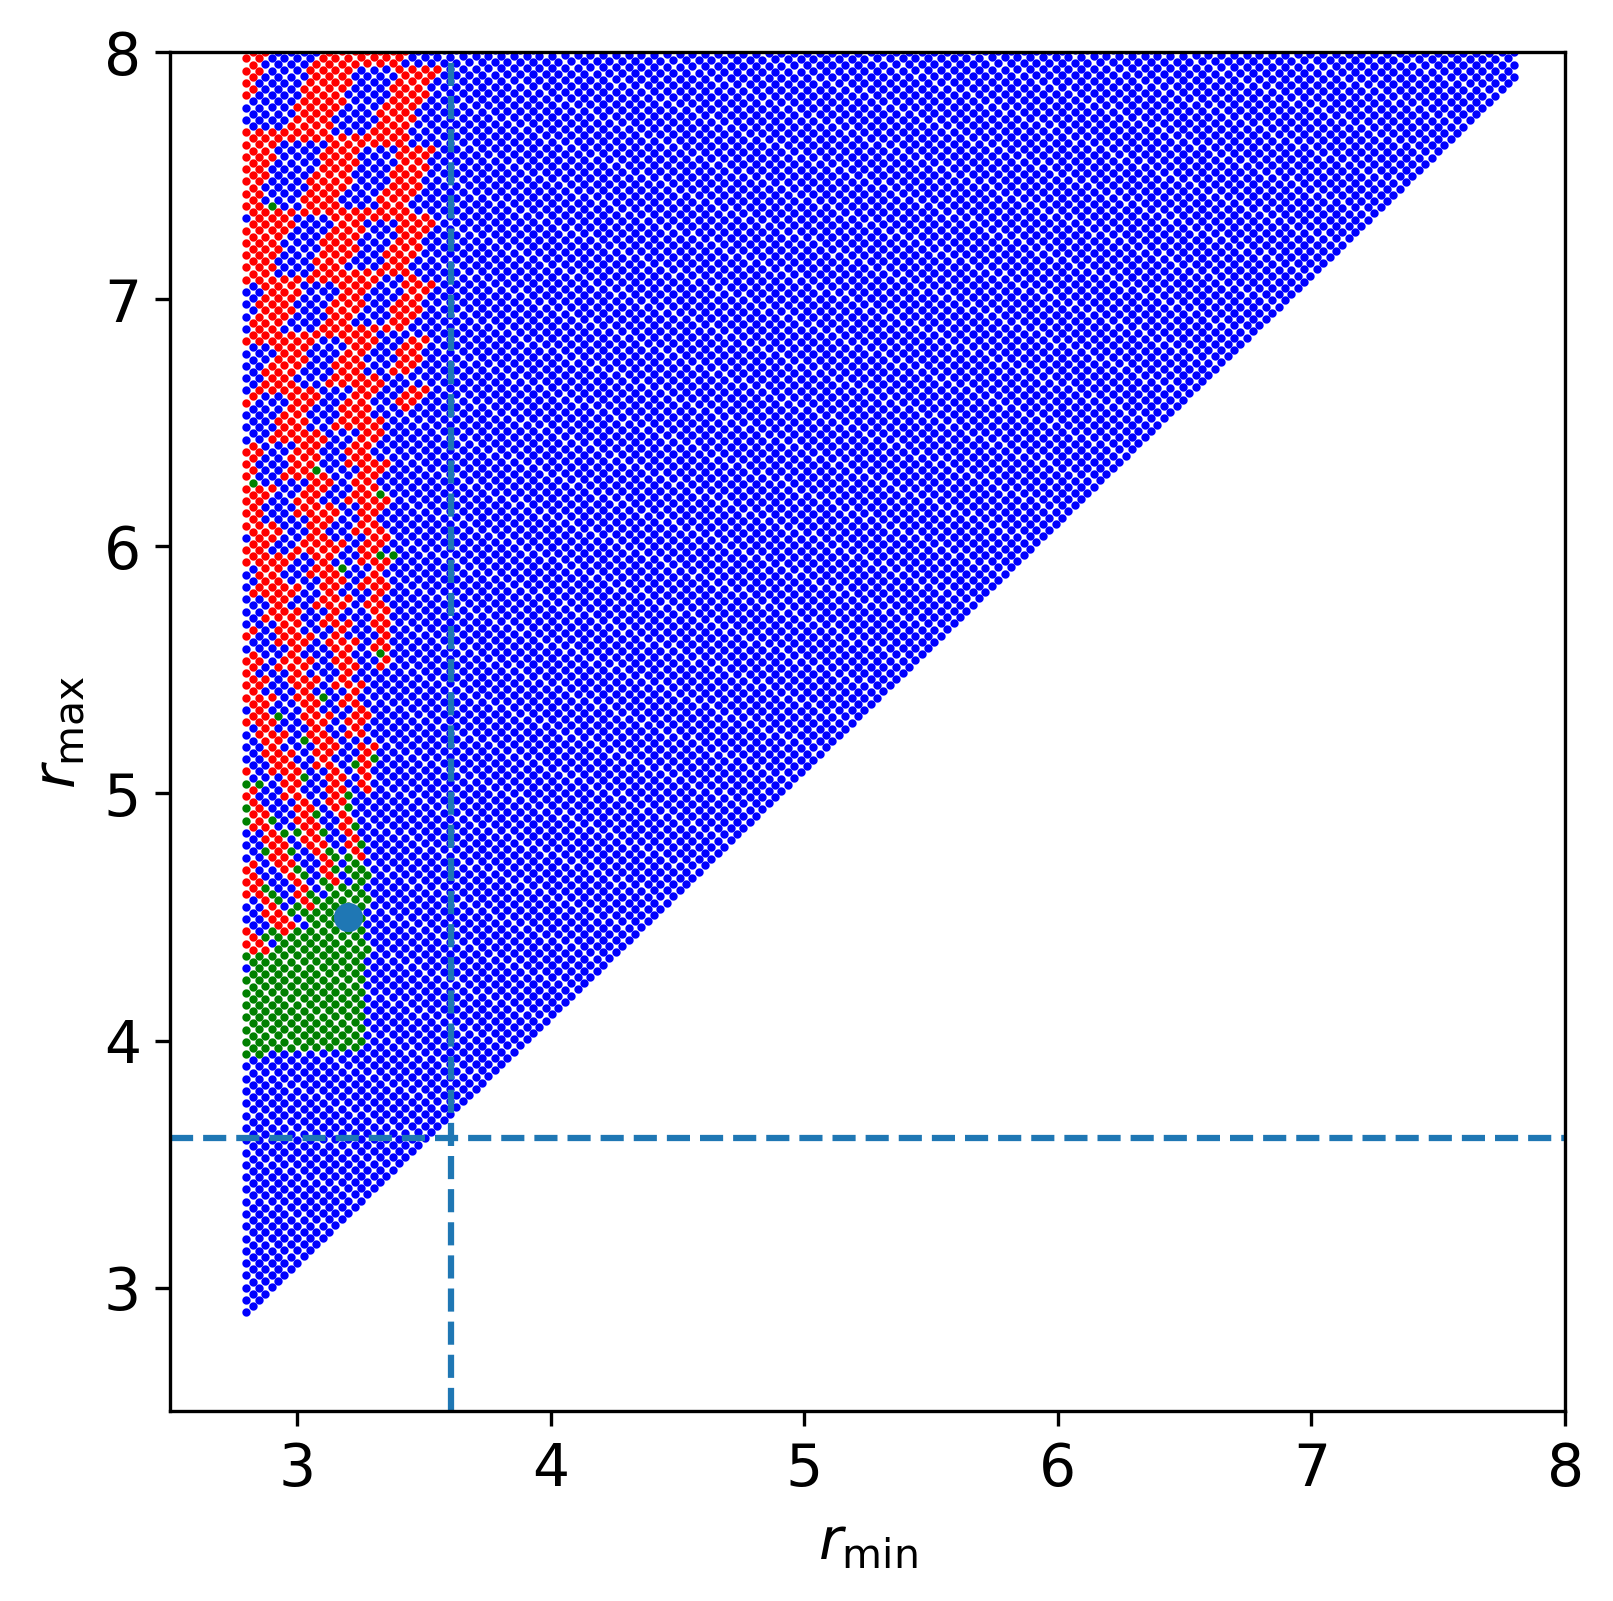

In [ ]:
i = 1
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es_list[i]
# plt.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# plt.colorbar()
plt.scatter(r_mins[es < e_refs[i] - error], r_maxs[es < e_refs[i] - error], c='red', s=1)
plt.scatter(r_mins[es > e_refs[i] + error], r_maxs[es > e_refs[i] + error], c='blue', s=1)
plt.scatter(r_mins[(es > e_refs[i] - error) & (es < e_refs[i] + error)], 
            r_maxs[(es > e_refs[i] - error) & (es < e_refs[i] + error)], c='green', s=1)

plt.scatter(3.2, 4.5)
# plt.yscale('log')
plt.xlim(2.5, 8)
plt.ylim(2.5, 8)
plt.xlabel('$r_{\\rm min}$')
plt.ylabel('$r_{\\rm max}$')
print(np.min(es))

plt.axvline(pot_mins[i], ls='--')
plt.axhline(pot_mins[i], ls='--')    
plt.show()
# r_new = np.linspace(lims[0], lims[0] + 5, 200)
# plt.plot(r_new, pot(r_new) * hartree, '--')
# plt.ylim(-1000, 5000)
# plt.show()

# r_new = np.linspace(lims[0] + 1, lims[0] + 20, 200)
# plt.plot(pot(r_new) * hartree, r_new, '--')
# plt.xlim(5000, -1000)
# plt.show()

5
-7619.267396486243


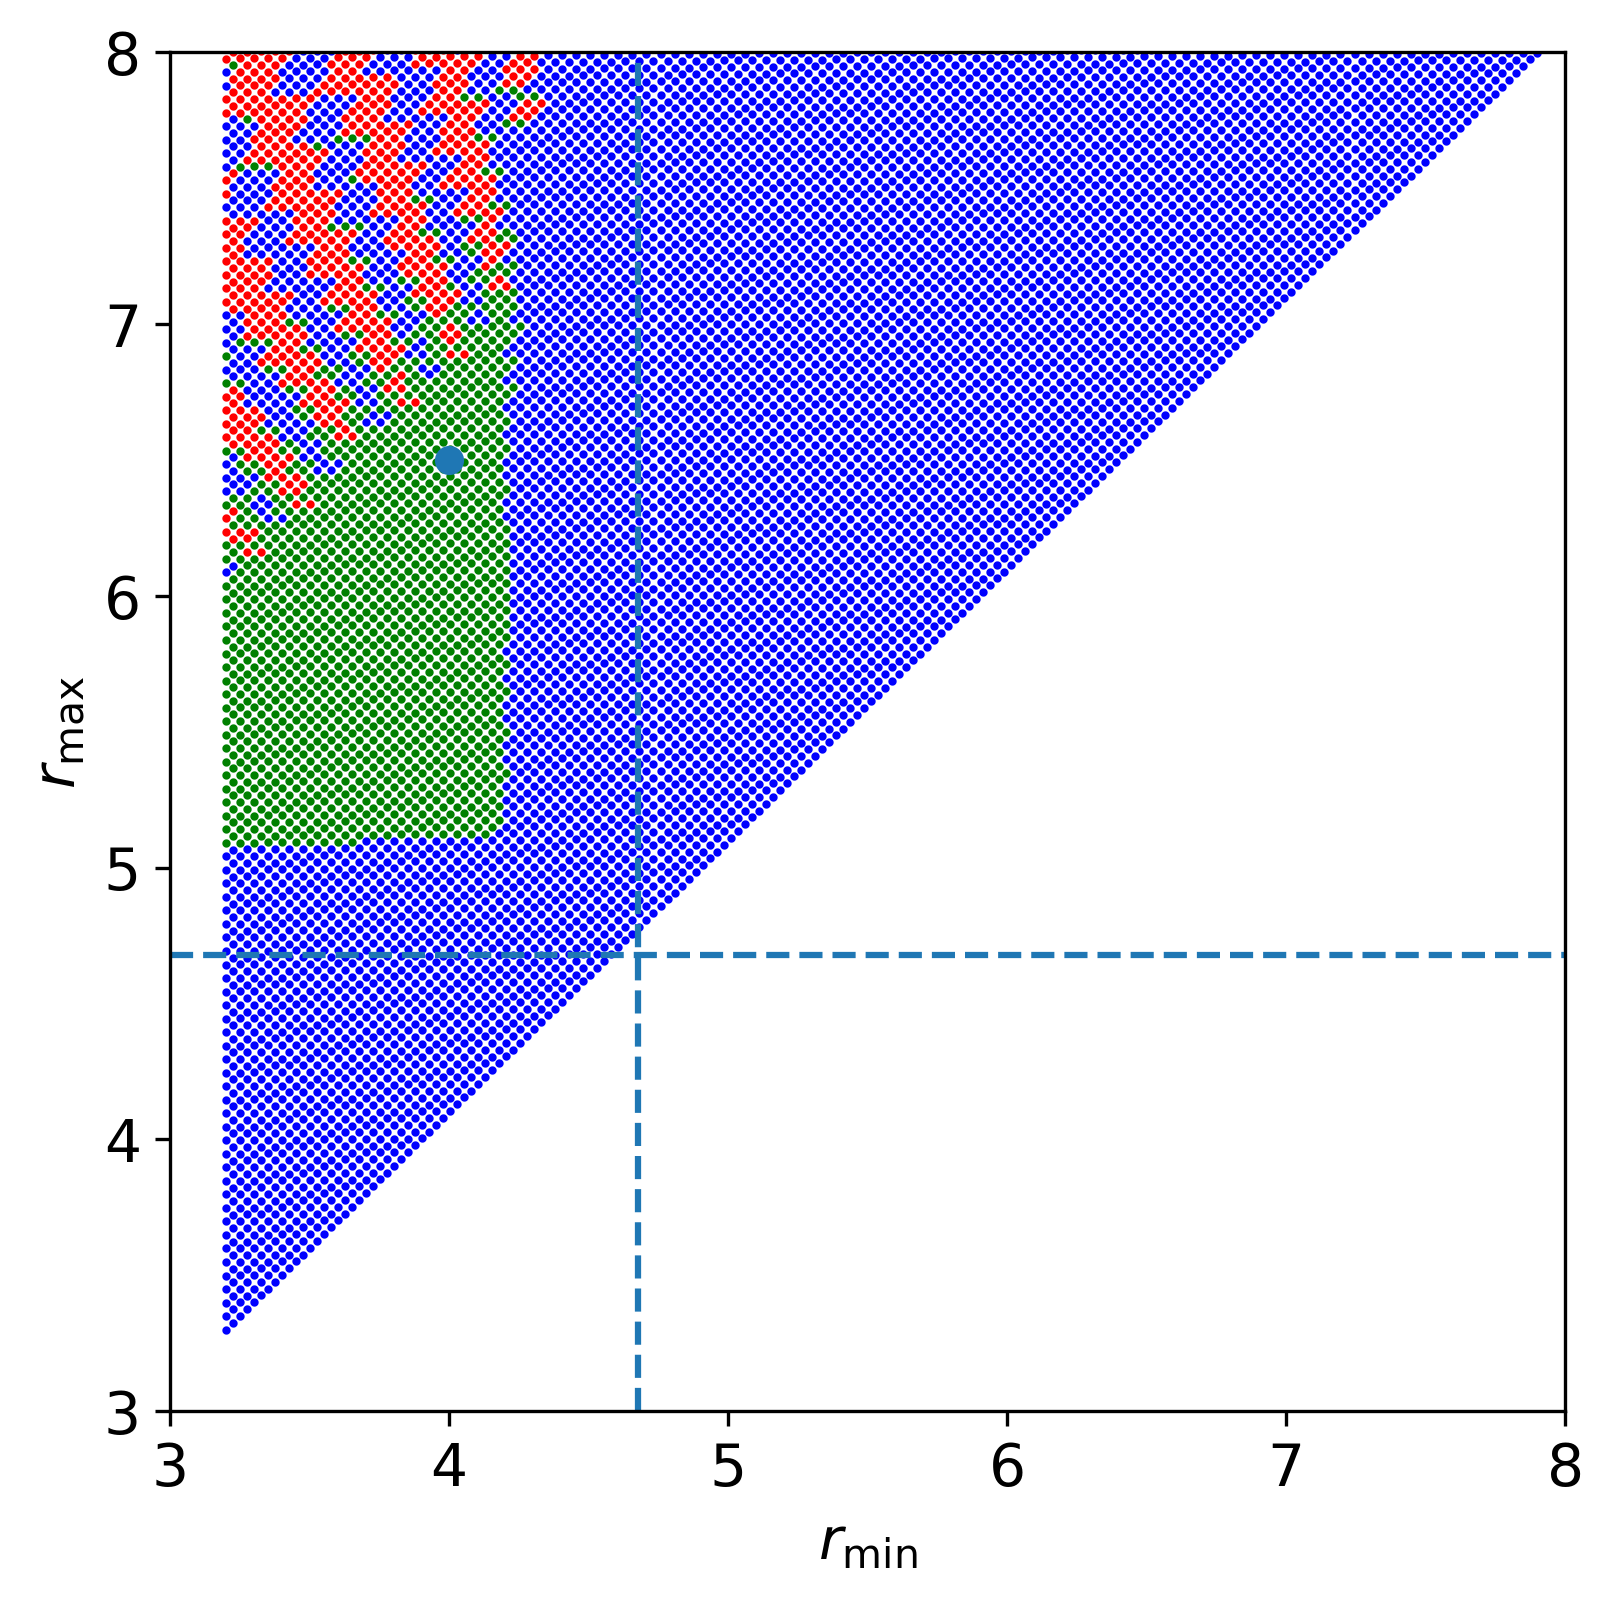

In [ ]:
i = 2
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es_list[i]
# plt.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# plt.colorbar()
plt.scatter(r_mins[es < e_refs[i] - error], r_maxs[es < e_refs[i] - error], c='red', s=1)
plt.scatter(r_mins[es > e_refs[i] + error], r_maxs[es > e_refs[i] + error], c='blue', s=1)
plt.scatter(r_mins[(es > e_refs[i] - error) & (es < e_refs[i] + error)], 
            r_maxs[(es > e_refs[i] - error) & (es < e_refs[i] + error)], c='green', s=1)

plt.scatter(4, 6.5)
# plt.yscale('log')
plt.xlim(3, 8)
plt.ylim(3, 8)
plt.xlabel('$r_{\\rm min}$')
plt.ylabel('$r_{\\rm max}$')
print(np.min(es))

plt.axvline(pot_mins[i], ls='--')
plt.axhline(pot_mins[i], ls='--')    
plt.show()
# r_new = np.linspace(lims[0], lims[0] + 5, 200)
# plt.plot(r_new, pot(r_new) * hartree, '--')
# plt.ylim(-1000, 5000)
# plt.show()

# r_new = np.linspace(lims[0] + 1, lims[0] + 20, 200)
# plt.plot(pot(r_new) * hartree, r_new, '--')
# plt.xlim(5000, -1000)
# plt.show()

7
-6584.011546219119


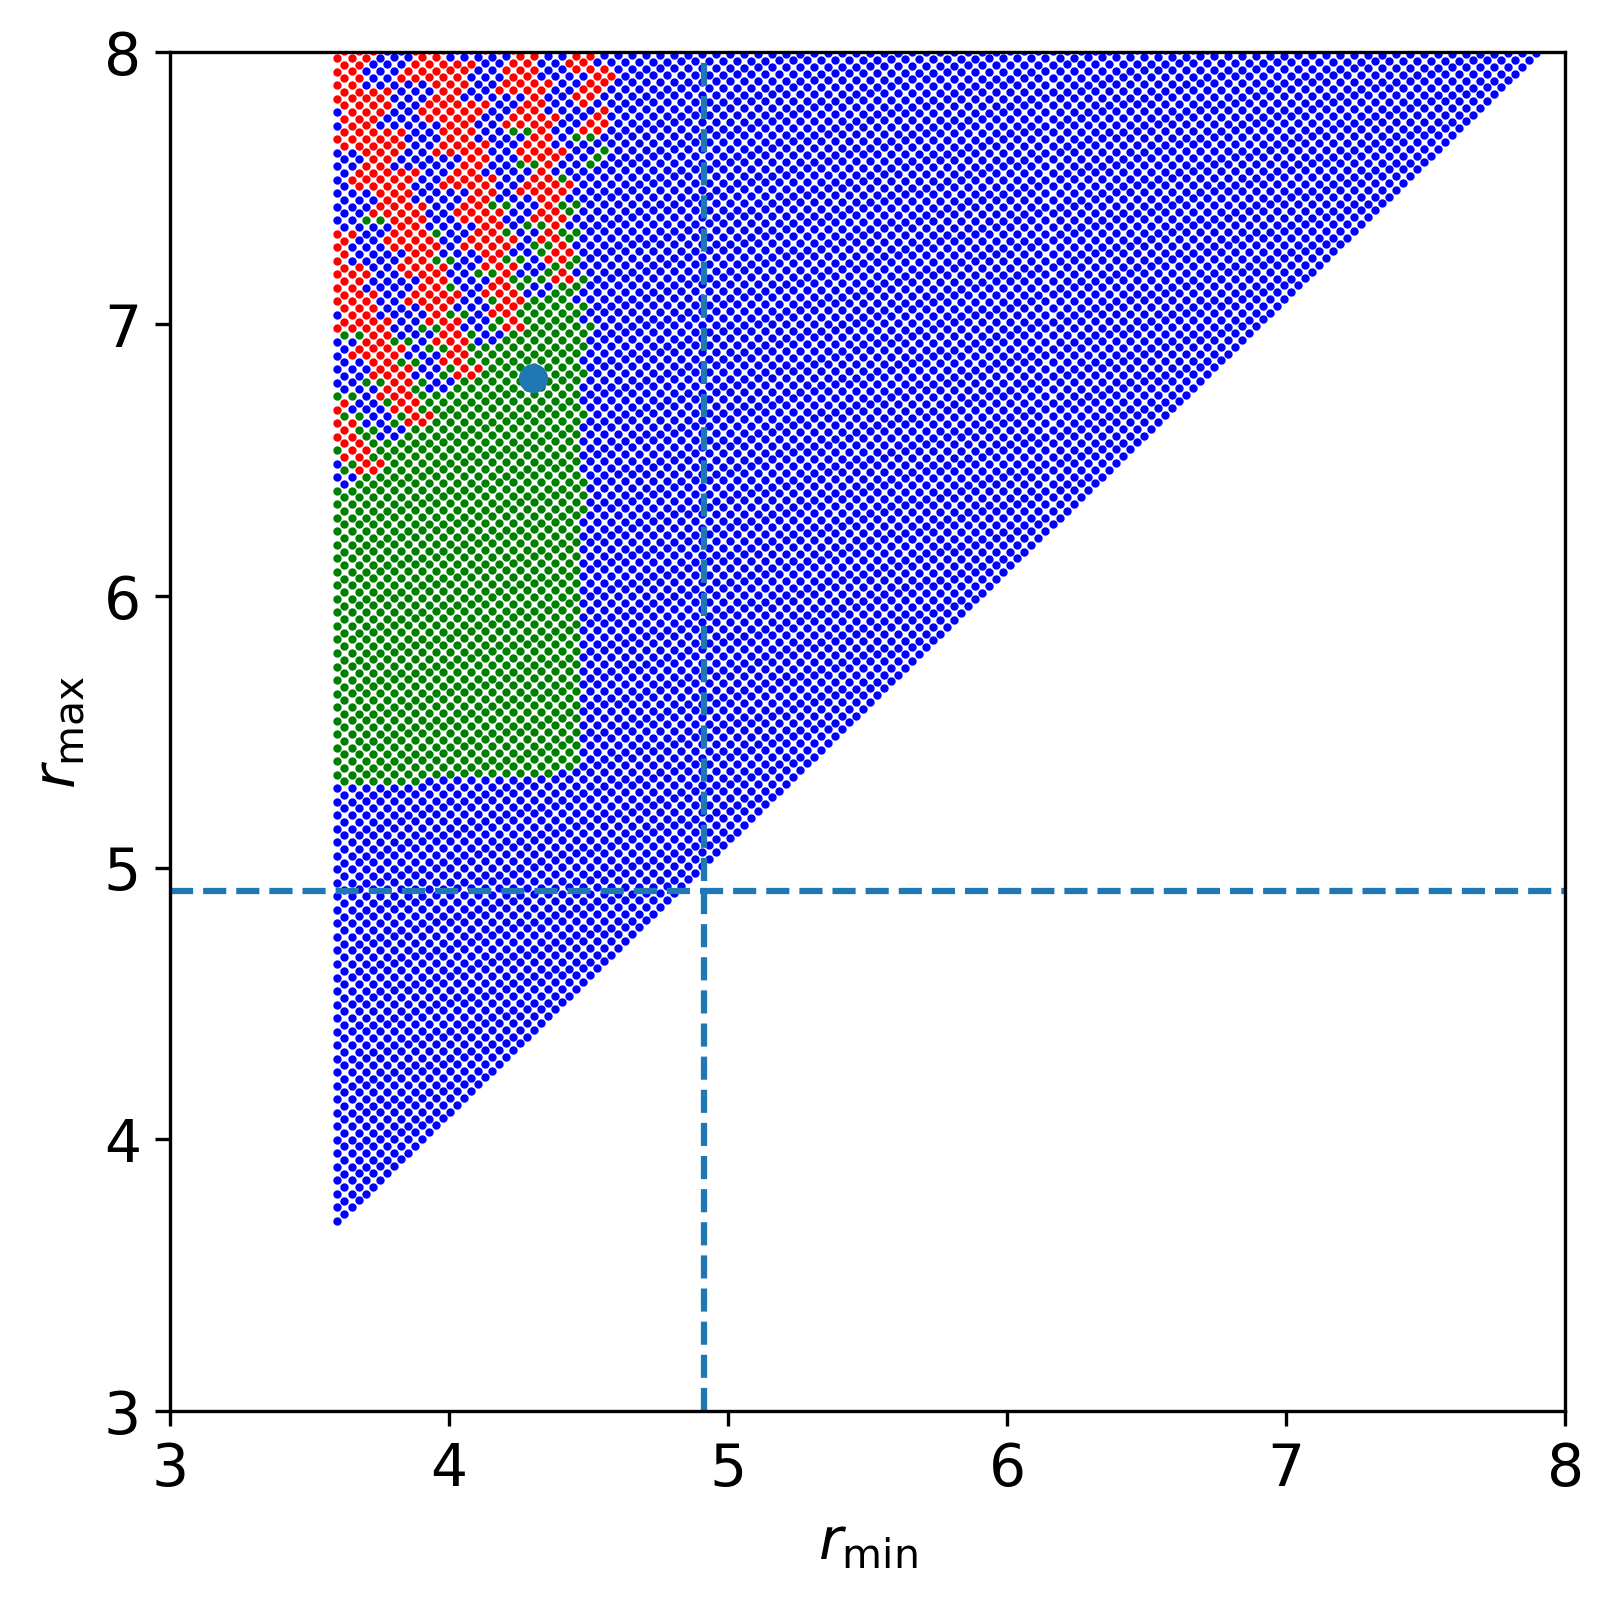

In [ ]:
i = 3
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es_list[i]
# plt.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# plt.colorbar()
plt.scatter(r_mins[es < e_refs[i] - error], r_maxs[es < e_refs[i] - error], c='red', s=1)
plt.scatter(r_mins[es > e_refs[i] + error], r_maxs[es > e_refs[i] + error], c='blue', s=1)
plt.scatter(r_mins[(es > e_refs[i] - error) & (es < e_refs[i] + error)], 
            r_maxs[(es > e_refs[i] - error) & (es < e_refs[i] + error)], c='green', s=1)

plt.scatter(4.3, 6.8)
# plt.yscale('log')
plt.xlim(3, 8)
plt.ylim(3, 8)
plt.xlabel('$r_{\\rm min}$')
plt.ylabel('$r_{\\rm max}$')
print(np.min(es))

plt.axvline(pot_mins[i], ls='--')
plt.axhline(pot_mins[i], ls='--')    
plt.show()
# r_new = np.linspace(lims[0], lims[0] + 5, 200)
# plt.plot(r_new, pot(r_new) * hartree, '--')
# plt.ylim(-1000, 5000)
# plt.show()

# r_new = np.linspace(lims[0] + 1, lims[0] + 20, 200)
# plt.plot(pot(r_new) * hartree, r_new, '--')
# plt.xlim(5000, -1000)
# plt.show()

9
-5417.466111239951


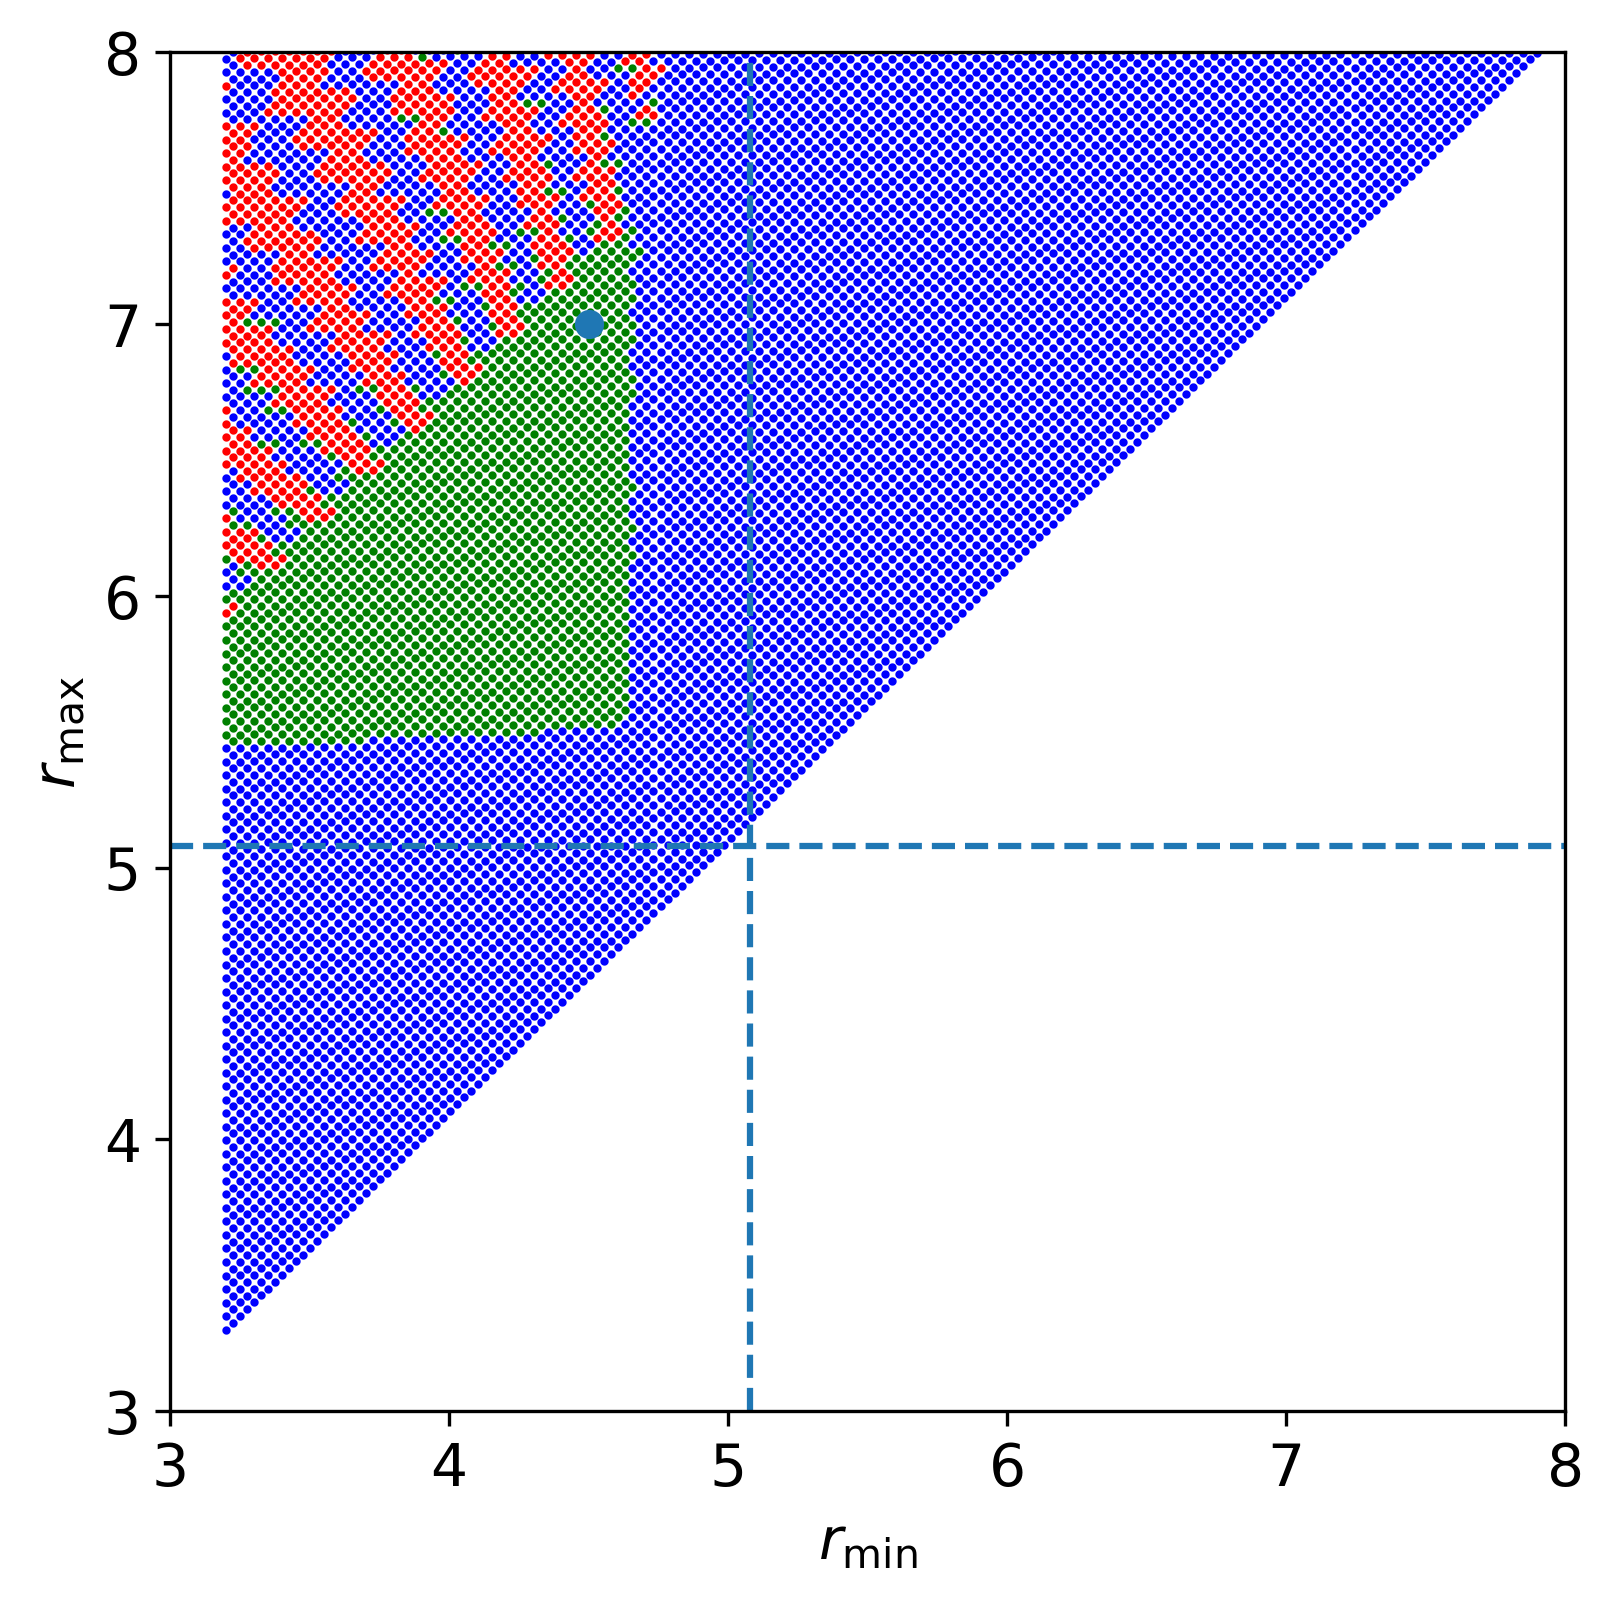

In [ ]:
i = 4
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es_list[i]
# plt.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# plt.colorbar()
plt.scatter(r_mins[es < e_refs[i] - error], r_maxs[es < e_refs[i] - error], c='red', s=1)
plt.scatter(r_mins[es > e_refs[i] + error], r_maxs[es > e_refs[i] + error], c='blue', s=1)
plt.scatter(r_mins[(es > e_refs[i] - error) & (es < e_refs[i] + error)], 
            r_maxs[(es > e_refs[i] - error) & (es < e_refs[i] + error)], c='green', s=1)

plt.scatter(4.5, 7)
# plt.yscale('log')
plt.xlim(3, 8)
plt.ylim(3, 8)
plt.xlabel('$r_{\\rm min}$')
plt.ylabel('$r_{\\rm max}$')
print(np.min(es))

plt.axvline(pot_mins[i], ls='--')
plt.axhline(pot_mins[i], ls='--')    
plt.show()
# r_new = np.linspace(lims[0], lims[0] + 5, 200)
# plt.plot(r_new, pot(r_new) * hartree, '--')
# plt.ylim(-1000, 5000)
# plt.show()

# r_new = np.linspace(lims[0] + 1, lims[0] + 20, 200)
# plt.plot(pot(r_new) * hartree, r_new, '--')
# plt.xlim(5000, -1000)
# plt.show()

11
-3745.898999643736


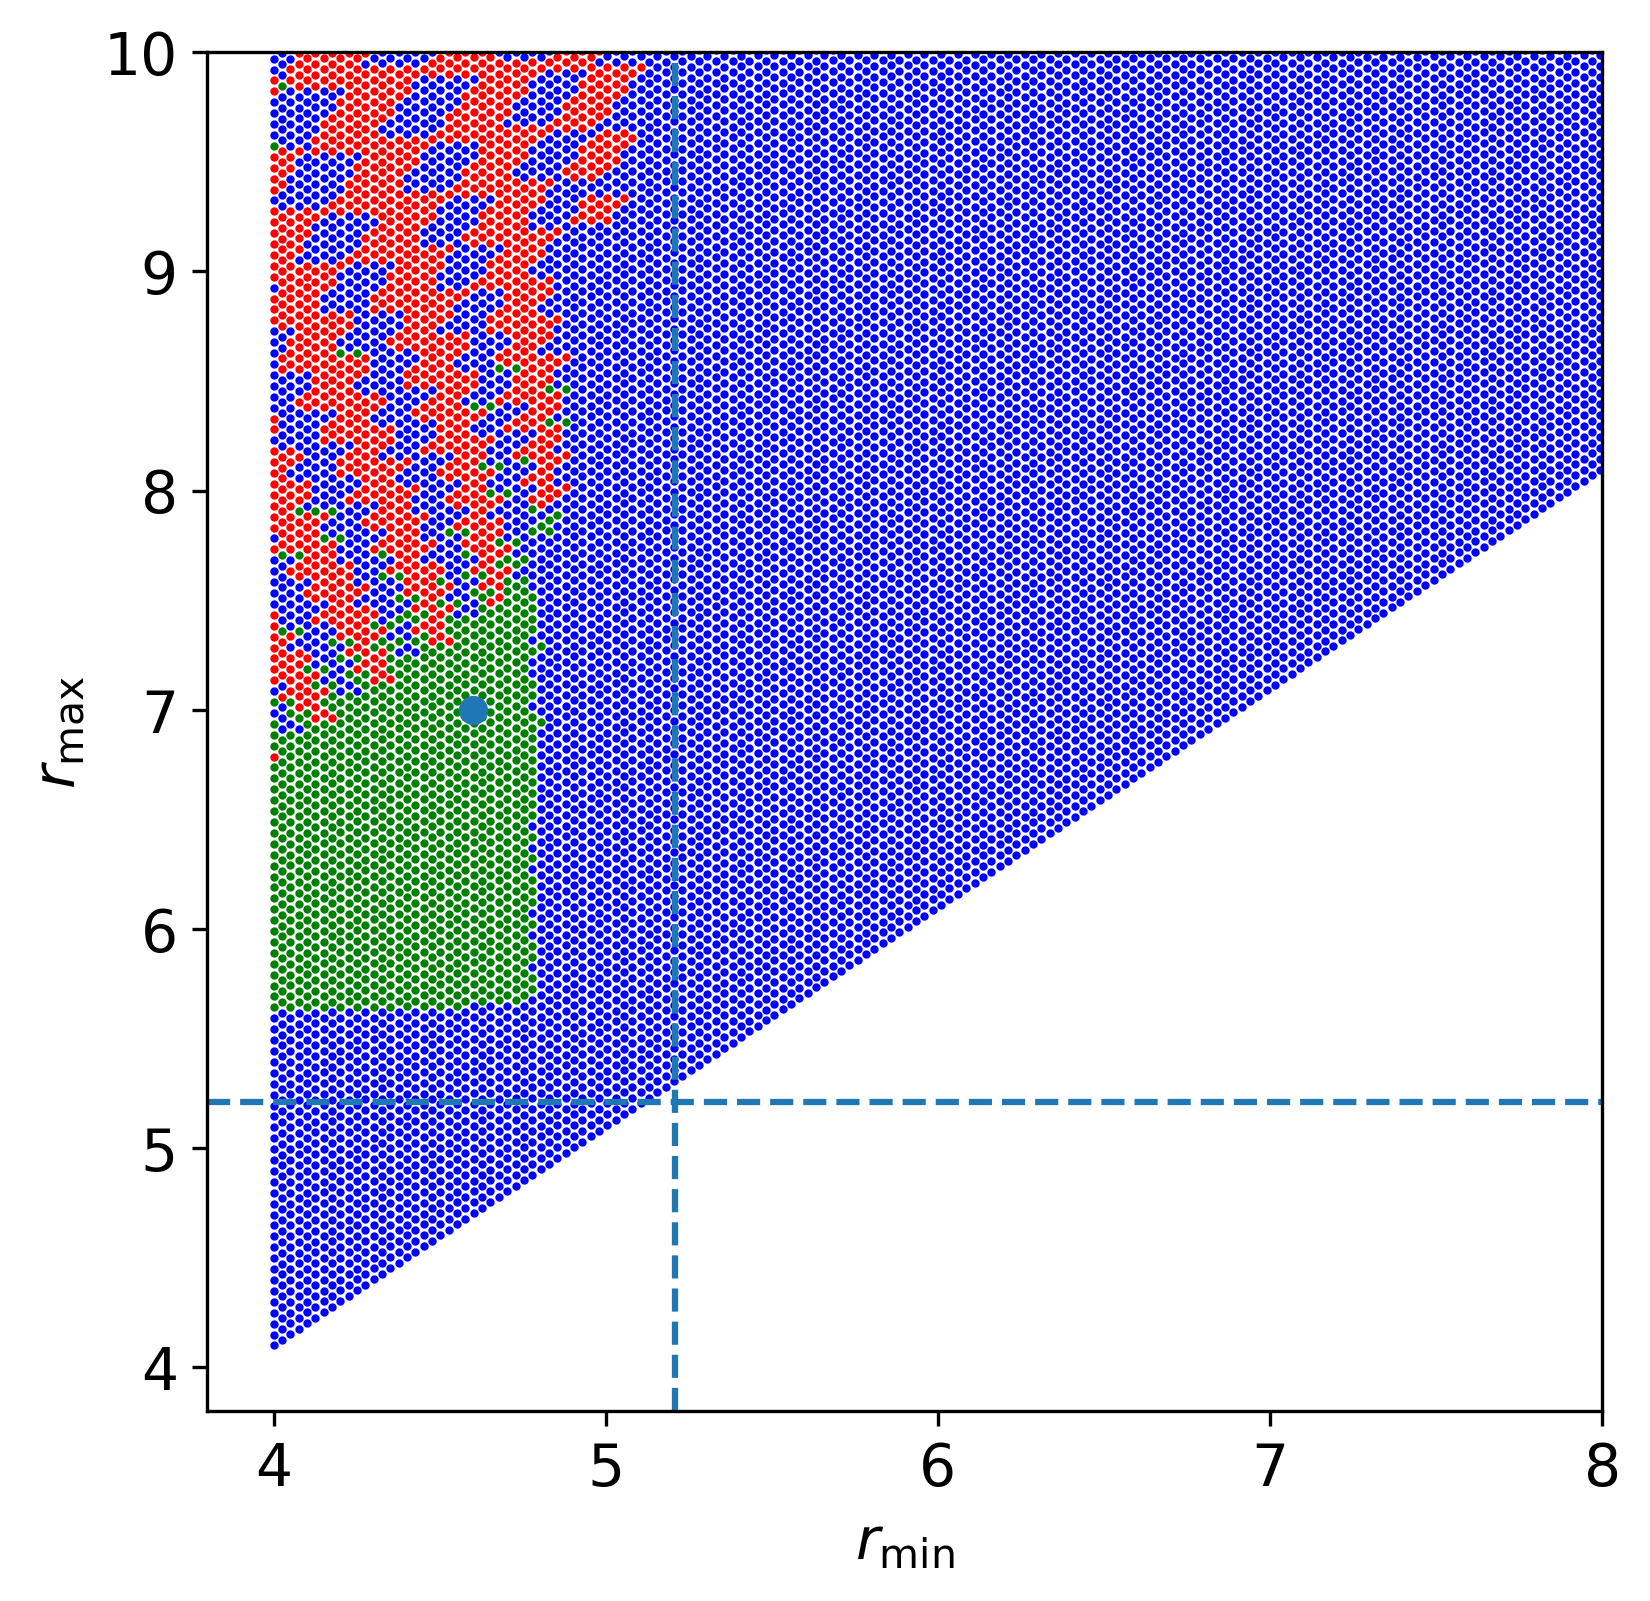

In [ ]:
i = 5
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es_list[i]
# plt.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# plt.colorbar()
plt.scatter(r_mins[es < e_refs[i] - error], r_maxs[es < e_refs[i] - error], c='red', s=1)
plt.scatter(r_mins[es > e_refs[i] + error], r_maxs[es > e_refs[i] + error], c='blue', s=1)
plt.scatter(r_mins[(es > e_refs[i] - error) & (es < e_refs[i] + error)], 
            r_maxs[(es > e_refs[i] - error) & (es < e_refs[i] + error)], c='green', s=1)

plt.scatter(4.6, 7)
# plt.yscale('log')
plt.xlim(3.8, 8)
plt.ylim(3.8, 10)
plt.xlabel('$r_{\\rm min}$')
plt.ylabel('$r_{\\rm max}$')
print(np.min(es))

plt.axvline(pot_mins[i], ls='--')
plt.axhline(pot_mins[i], ls='--')    
plt.show()
# r_new = np.linspace(lims[0], lims[0] + 5, 200)
# plt.plot(r_new, pot(r_new) * hartree, '--')
# plt.ylim(-1000, 5000)
# plt.show()

# r_new = np.linspace(lims[0] + 1, lims[0] + 20, 200)
# plt.plot(pot(r_new) * hartree, r_new, '--')
# plt.xlim(5000, -1000)
# plt.show()

13
-558.8792382220414


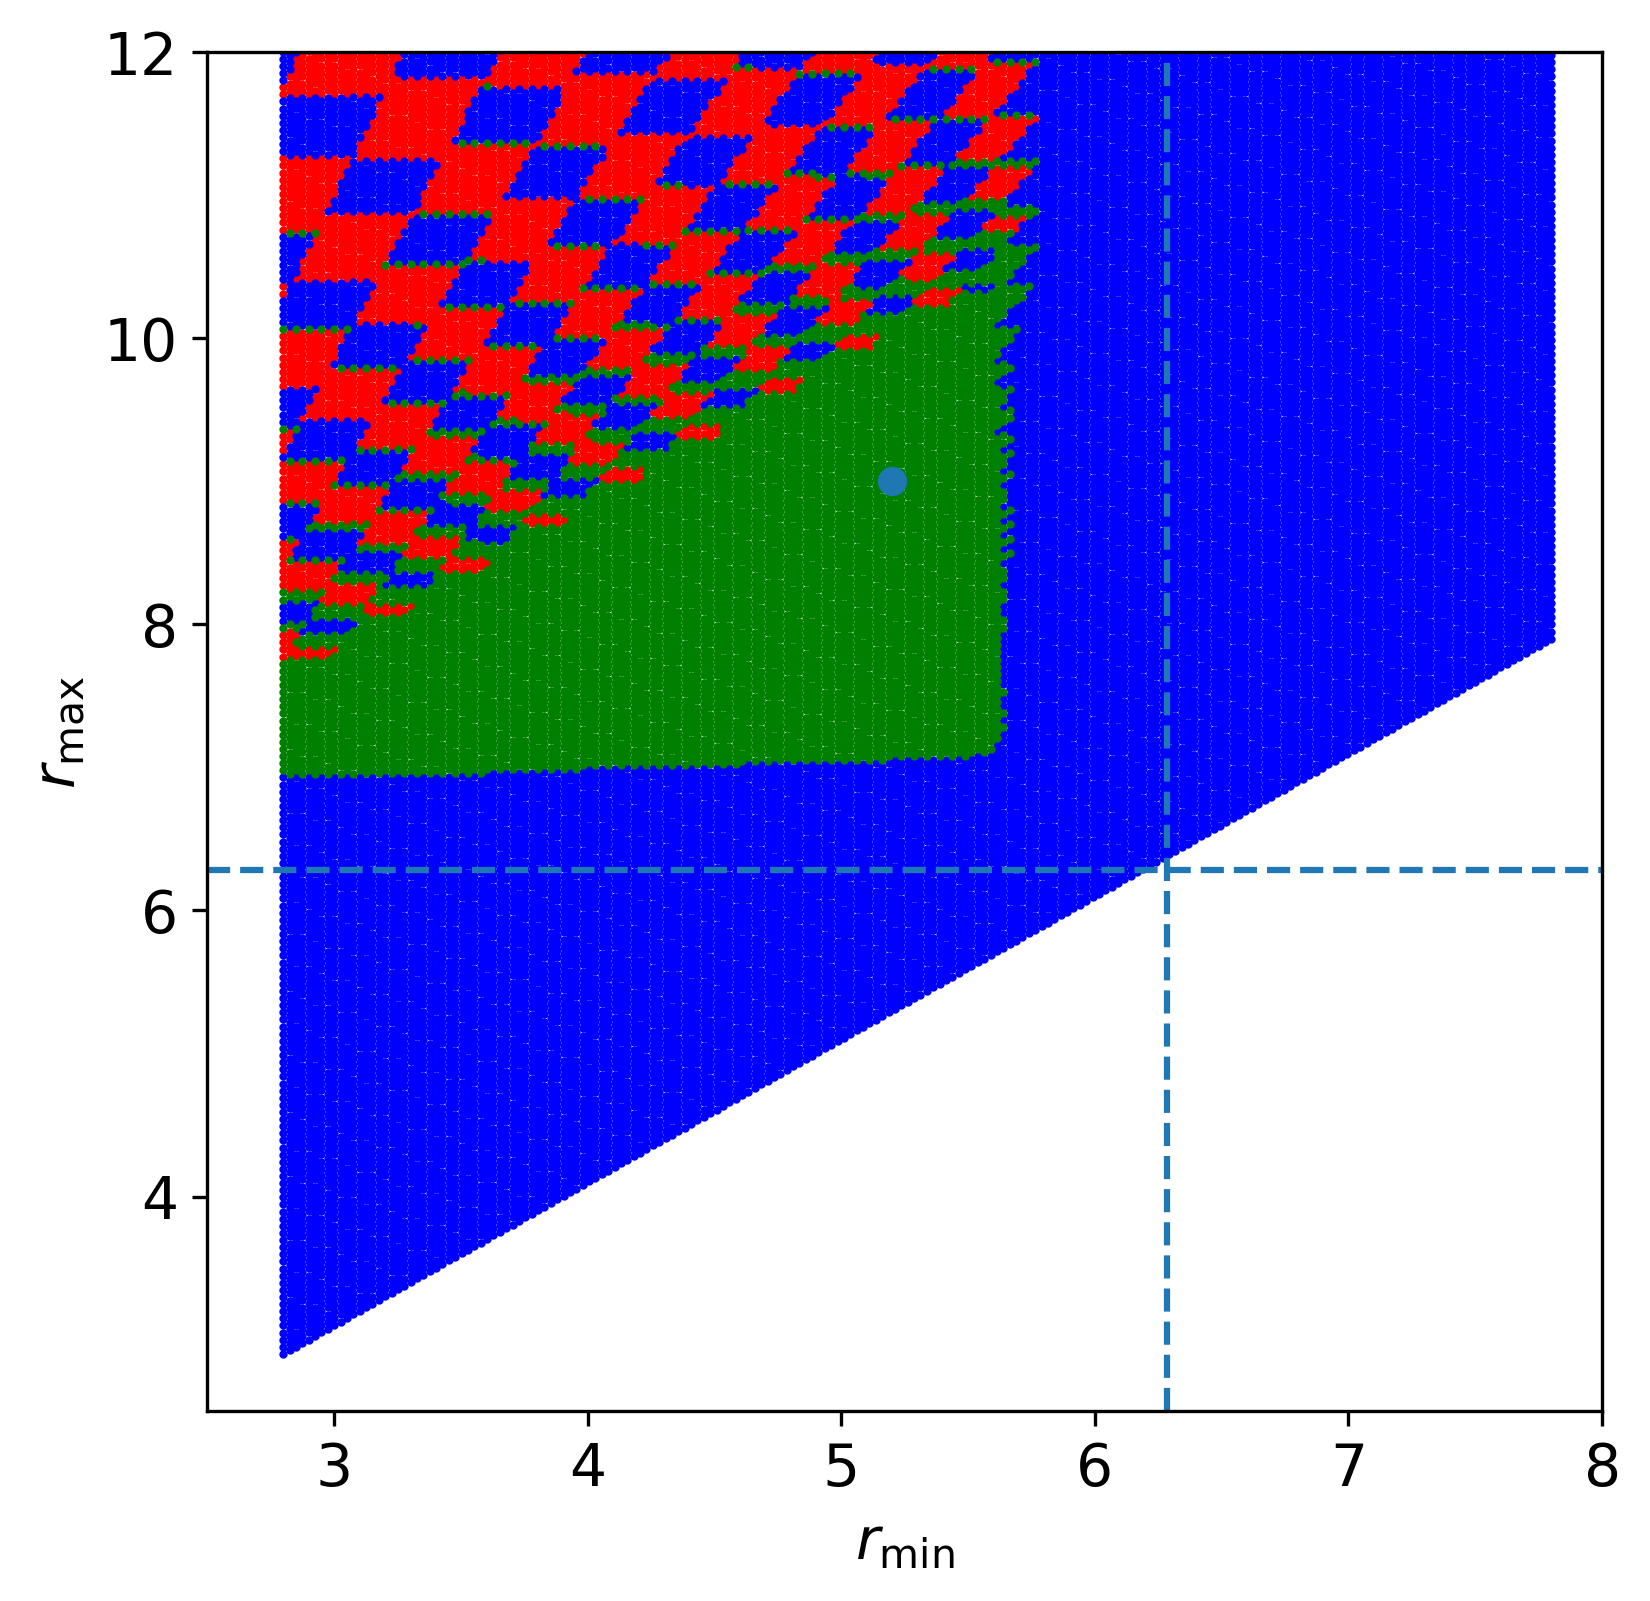

In [47]:
i = 6
spin = spins[i]
print(spin)
r_mins = r_mins_list[i]
drs = drs_list[i]
r_maxs = np.array(r_mins) + np.array(drs)
es = es_list[i]
# plt.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# plt.colorbar()
plt.scatter(r_mins[es < e_refs[i] - error], r_maxs[es < e_refs[i] - error], c='red', s=1)
plt.scatter(r_mins[es > e_refs[i] + error], r_maxs[es > e_refs[i] + error], c='blue', s=1)
plt.scatter(r_mins[(es > e_refs[i] - error) & (es < e_refs[i] + error)], 
            r_maxs[(es > e_refs[i] - error) & (es < e_refs[i] + error)], c='green', s=1)

plt.scatter(5.2, 9)
# plt.yscale('log')
plt.xlim(2.5, 8)
plt.ylim(2.5, 12)
plt.xlabel('$r_{\\rm min}$')
plt.ylabel('$r_{\\rm max}$')
print(np.min(es))

plt.axvline(pot_mins[i], ls='--')
plt.axhline(pot_mins[i], ls='--')    
plt.show()
# r_new = np.linspace(lims[0], lims[0] + 5, 200)
# plt.plot(r_new, pot(r_new) * hartree, '--')
# plt.ylim(-1000, 5000)
# plt.show()

# r_new = np.linspace(lims[0] + 1, lims[0] + 20, 200)
# plt.plot(pot(r_new) * hartree, r_new, '--')
# plt.xlim(5000, -1000)
# plt.show()

In [69]:
spin = 13
r_min, dx = (5, 0.5)
n = 16
# print(params)
dvr_options = {
    'type': '1d',
    'box_lims': (r_min, r_min + (n * dx)),
    'dx': dx,
    'count': n
}

pot, lims = get_pot_cr2(spin)
print(lims)
dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')
r_dvr = dvr_vqe.get_DVR_Rtheta(dvr_options)
print(r_dvr)

(2.8, 40.0)
[ 5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.
 12.5 13. ]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(-800.0, 2000.0)

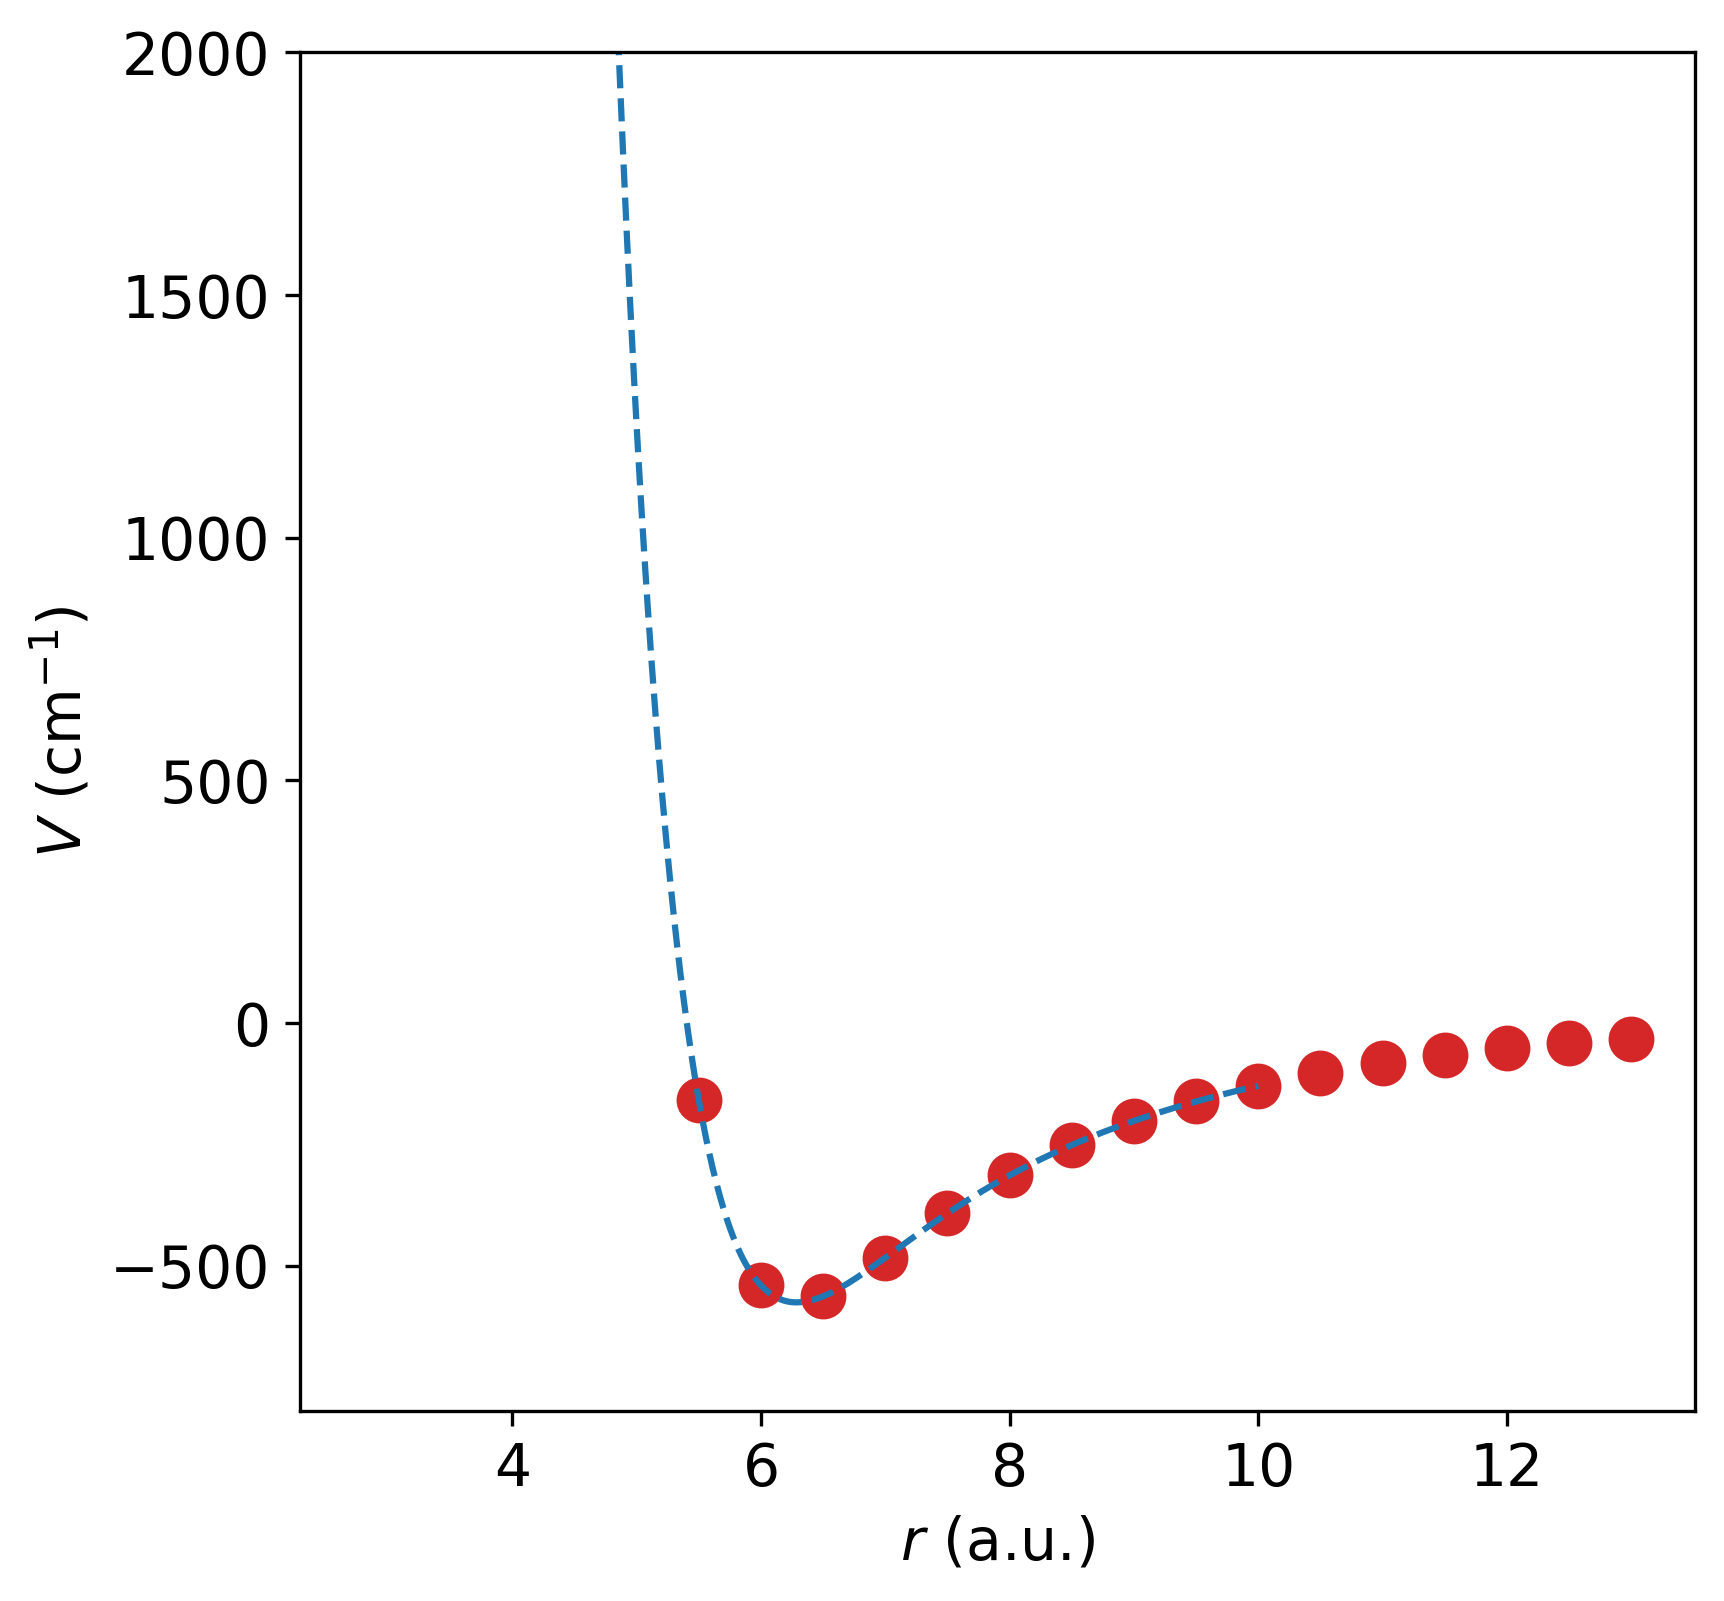

In [70]:
r_new = np.linspace(lims[0], 10, 1000)
cmap = plt.get_cmap('tab10')
plt.plot(r_new, pot(r_new) * hartree, '--', c=cmap(0))
# plt.scatter(r_box1, v1 * hartree, marker='o', s=100, c=cmap(1))
plt.scatter(r_dvr, pot(r_dvr) * hartree, marker='o', s=100, c=cmap(3))
plt.xlabel('$r$ (a.u.)')
plt.ylabel('$V$ (cm$^{-1}$)')
plt.ylim(-800, 2000)
#-540.2707144837274882 0.001 5-8
#-548.6810730737634003

13
-569.0648443007883


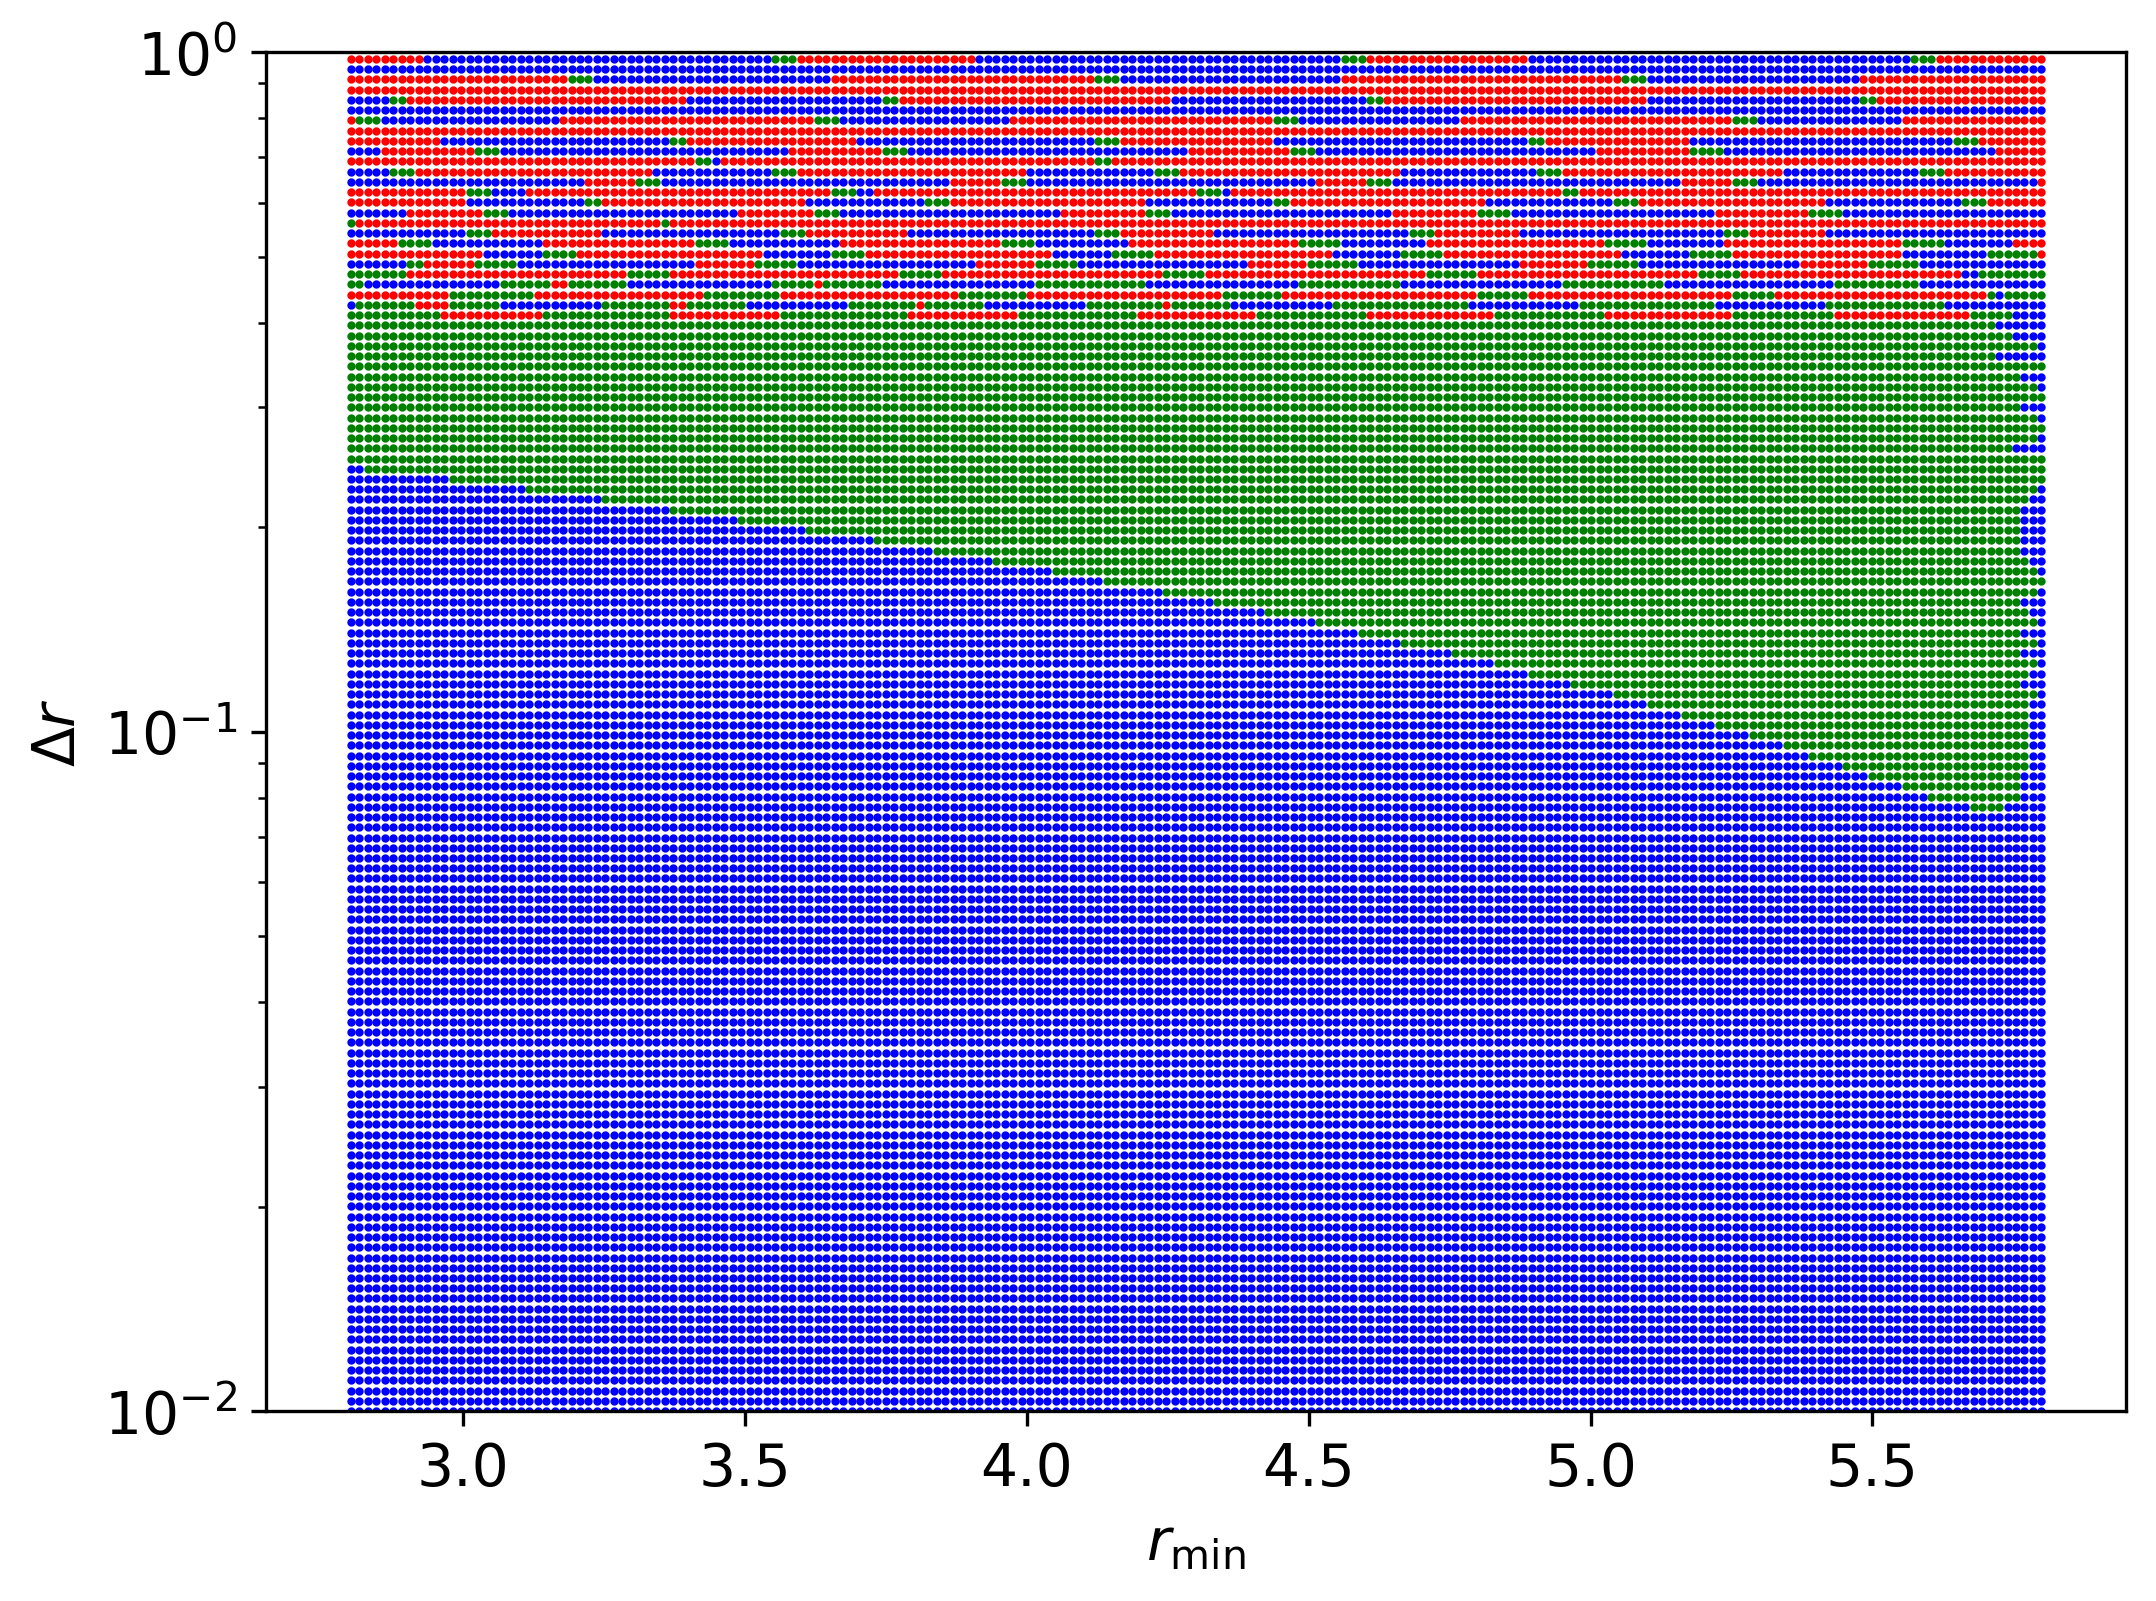

In [27]:
# plt.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
# e_refs = [-15358.93684293, -9862.06667487, -7566.52568343, -6519.00988272, -5348.79450816, -3677.68306697, -548.68107280]
e_refs = [-548.68107280]
spins = [13]
# spins = [1, 3, 5, 7, 9, 11, 13]
for i, spin in enumerate(spins):
    print(spin)
    r_mins = r_mins_list[i]
    dxs = dxs_list[i]
    es = es2_list[i]
    # plt.tricontourf(r_mins[es < 0], dxs[es < 0], es[es < 0])
    # plt.colorbar()
    plt.scatter(r_mins[es < e_refs[i] - 1], dxs[es < e_refs[i] - 1], c='red', s=1)
    plt.scatter(r_mins[es > e_refs[i] + 1], dxs[es > e_refs[i] + 1], c='blue', s=1)
    plt.scatter(r_mins[(es > e_refs[i] - 1) & (es < e_refs[i] + 1)], dxs[(es > e_refs[i] - 1) & (es < e_refs[i] + 1)], c='green', s=1)
    plt.yscale('log')
    plt.ylim(0.01, 1)
    plt.xlabel('$r_{\\rm min}$')
    plt.ylabel('$\Delta r$')
    print(np.min(es))
    plt.show()

In [10]:
from scipy.optimize import minimize

# for spin in [3]:
for spin in [1, 3, 5, 7, 9, 11, 13]:
    mol_params = cr2_params
    mol_params['name'] = f'cr2_{spin}'
    print(mol_params['name'])

    pot, lims = get_pot_cr2(spin)
    print(lims)

    dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')

    # fun8 = lambda p: get_gs_energy(p, dvr_vqe, 8)
    # # opt8 = minimize(fun8, (lims[0] + 0.5, dx), method='Powell', bounds=[(lims[0], lims[1]), (0.001, 0.1)])
    # opt8 = minimize(fun8, (lims[0] + 0.5, dx), bounds=[(lims[0], lims[1]), (0.001, 0.1)])
    # print(opt8.x, opt8.fun)
    # print('---------------------------')
    bounds = [(lims[0], lims[0] + 5)]
    fun16 = lambda p: get_gs_energy(p, dvr_vqe, 16)
    # opt16 = minimize(fun16, (lims[0] + 0.5, dx), method='Powell', bounds=[(lims[0], lims[1]), (0.001, 0.1)])
    opt16 = minimize(fun16, (lims[0] + 0.5), method='Powell', options=dict())
    print(opt16.x, opt16.fun)
    print('***************************')

cr2_1
(2.6, 40.0)
[2.3714571] -15359.517318281763
***************************
cr2_3
(2.8, 40.0)
[3.3] -9862.284701816594
***************************
cr2_5
(3.2, 40.0)
[4.07017916] -7566.529699961182
***************************
cr2_7
(3.6, 40.0)
[4.25918157] -6519.010866925086
***************************
cr2_9
(3.2, 40.0)
[4.15823113] -5348.796255515593
***************************
cr2_11
(4.0, 40.0)
[4.46044443] -3677.686900348253
***************************
cr2_13
(2.8, 40.0)
[5.56386174] -548.6321400516745
***************************


In [24]:
from scipy.optimize import minimize

for spin in [3]:
# for spin in [1, 3, 5, 7, 9, 11, 13]:
    mol_params = cr2_params
    mol_params['name'] = f'cr2_{spin}'
    print(mol_params['name'])

    pot, lims = get_pot_cr2(spin)
    print(lims)

    dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')

    # fun8 = lambda p: get_gs_energy(p, dvr_vqe, 8)
    # # opt8 = minimize(fun8, (lims[0] + 0.5, dx), method='Powell', bounds=[(lims[0], lims[1]), (0.001, 0.1)])
    # opt8 = minimize(fun8, (lims[0] + 0.5, dx), bounds=[(lims[0], lims[1]), (0.001, 0.1)])
    # print(opt8.x, opt8.fun)
    # print('---------------------------')
    bounds = [(lims[0], lims[0] + 5), (0.001, 1)]
    fun16 = lambda p: get_gs_energy(p, dvr_vqe, bounds, 16)
    # opt16 = minimize(fun16, (lims[0] + 0.5, dx), method='Powell', bounds=[(lims[0], lims[1]), (0.001, 0.1)])
    opt16 = minimize(fun16, (lims[0] + 0.5, 0.02), method='Powell', options=dict())
    print(opt16.x, opt16.fun)
    print('***************************')

cr2_3
(2.8, 40.0)
[3.3  0.02]
-9597.76363662194
[3.3  0.02]
-9597.76363662194
[4.3  0.02]
-8498.797856738354
[1.681966 0.02    ]
-1988.4634777763156
[3.3  0.02]
-9597.76363662194
[2.68196603 0.02      ]
-1988.4634777763156
[3.681966 0.02    ]
-9394.582496813786
[3.47027553 0.02      ]
-9771.692174840402
[3.45473785 0.02      ]
-9777.730085241397
[3.44118449 0.02      ]
-9778.05524473803
[3.44700408 0.02      ]
-9778.26873138327
[3.44553404 0.02      ]
-9778.265361830936
[3.44847412 0.02      ]
-9778.238145587988
[3.44700408 0.02      ]
-9778.26873138327
[3.44700408 1.02      ]
-9075.867740694415
[ 3.44700408 -1.598034  ]
71711.38869657015
[3.44700408 0.02      ]
-9778.26873138327
[ 3.44700408 -0.59803397]
71711.38869657015
[3.44700408 0.401966  ]
-9871.505676064684
[3.44700408 0.21191036]
-9871.86680392623
[3.44700408 0.30619701]
-9829.152276802271
[3.44700408 0.13860713]
-9842.219848358123
[3.44700408 0.24792465]
-9911.096801136213
[3.44700408 0.27018271]
-9933.601417620803
[3.4470040

In [16]:
ansatz_options = {
    'type': 'twolocal',
    'rotation_blocks': ['ry'],
    'entanglement_blocks': 'cx',
    'entanglement': 'full',
    'reps': 2
}

vqe_options = {
    # 'optimizers': ['COBYLA.8000', 'L_BFGS_B.8000', 'SLSQP.1000'],
    'optimizers': ['SLSQP.1000'],
    'repeats': 1, 
    # 'repeats': 5, 
    'beta': [],
    'seed': 42
}

mol_params = cr2_params
spin = 5
mol_params['name'] = f'cr2_{spin}'
print(mol_params['name'])

pot, lims = get_pot_cr2(spin)
print(lims)

dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')

def get_gs_energy_vqe(params, dvr_vqe, n):
    r_min, dx = params
    print(params)
    dvr_options = {
        'type': '1d',
        'box_lims': (r_min, r_min + n * dx),
        'dx': dx
    }

    h_dvr = dvr_vqe.get_h_dvr(dvr_options)[:16, :16] * hartree
    print(h_dvr.shape)
    num_qubits = int(np.log2(h_dvr.shape[0]))
    h_dvr_pauli = pauli_decompose(h_dvr)

    ansatz = dvr_vqe.get_ansatz(ansatz_options, num_qubits)
    converge_cnts, converge_vals, best_params, best_energies = dvr_vqe.opt_vqe(h_dvr_pauli, ansatz, vqe_options, 
                                                                                log_file=None)
    return converge_vals[0][-1]

print(get_gs_energy((3.29, 0.1), dvr_vqe, 16))
print(get_gs_energy_vqe((3.29, 0.1), dvr_vqe, 16))


cr2_5
(3.2, 40.0)
-7559.465506424531
(3.29, 0.1)
(16, 16)


c:\Users\kasna\OneDrive - UBC\arc\root\project\dvr_vqe\2d\lib\utils.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  coefs[i] = np.trace(np.dot(p.to_matrix(), h)) / 2**num_qubits


Optimizer: SLSQP        
680, -7559.4639801227915
Optimization complete
-7559.4639810870285


In [42]:
from scipy.optimize import minimize

for spin in [5]:
    mol_params = cr2_params
    mol_params['name'] = f'cr2_{spin}'
    print(mol_params['name'])

    pot, lims = get_pot_cr2(spin)
    print(lims)

    dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')

    # fun8 = lambda p: get_gs_energy(p, dvr_vqe, 8)
    # opt8 = minimize(fun8, (lims[0] + 0.5, dx), method='Powell', bounds=[(lims[0], lims[1]), (0.001, 0.1)])
    # print(opt8.x, opt8.fun)
    # print('---------------------------')
    fun16 = lambda p: get_gs_energy_vqe(p, dvr_vqe, 16)
    # opt16 = minimize(fun16, (lims[0] + 0.49, 0.1), method='Powell', bounds=[(lims[0], lims[1]), (0.001, 0.1)], options={'maxfev': 20, 'disp': True})
    # opt16 = minimize(fun16, (lims[0] + 0.49, 0.05), method='trust-constr', bounds=[(lims[0], lims[0] + 5), (0.001, 0.1)], options=dict(verbose=1))
    opt16 = minimize(fun16, (lims[0] + 0.49, 0.05), method='L-BFGS-B', bounds=[(lims[0], lims[0] + 5), (0.001, 0.1)], 
                    options=dict(eps=1e-5, verbose=1))
    print(opt16.x, opt16.fun)
    print('***************************')

cr2_5
(3.2, 40.0)
[3.69 0.05]
(16, 16)


C:\Users\kasna\AppData\Local\Temp\ipykernel_13496\1015347053.py:20: OptimizeWarning: Unknown solver options: verbose
  opt16 = minimize(fun16, (lims[0] + 0.49, 0.05), method='L-BFGS-B', bounds=[(lims[0], lims[0] + 5), (0.001, 0.1)],


Optimizer: SLSQP        
1130, -7209.962764271087
Optimization complete
[3.69001 0.05   ]
(16, 16)
Optimizer: SLSQP        
1070, -7209.980710657777
Optimization complete
[3.69    0.05001]
(16, 16)
Optimizer: SLSQP        
2930, -7210.2498406731815
Optimization complete
[8.2 0.1]
(16, 16)
Optimizer: SLSQP        
510, -799.92800648125344
Optimization complete
[8.19999 0.1    ]
(16, 16)
Optimizer: SLSQP        
630, -799.93378209681416
Optimization complete
[8.2     0.09999]
(16, 16)
Optimizer: SLSQP        
980, -788.92094050619115
Optimization complete
[3.94465192 0.05282319]
(16, 16)
Optimizer: SLSQP        
750, -7519.8668774256135
Optimization complete
[3.94466192 0.05282319]
(16, 16)
Optimizer: SLSQP        
780, -7519.8709485939755
Optimization complete
[3.94465192 0.05283319]
(16, 16)
Optimizer: SLSQP        
800, -7519.9319773343075
Optimization complete
[4.01938708 0.05364987]
(16, 16)
Optimizer: SLSQP        
1760, -7545.7401026468725
Optimization complete
[4.01939708 0.05364

KeyboardInterrupt: 

In [10]:
opt16

   direc: array([[1., 0.],
       [0., 1.]])
     fun: -547.8765085930911
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 20
     nit: 0
  status: 1
 success: False
       x: array([5.4720599, 0.1      ])